In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm import tqdm
from typing import *

In [2]:
import warnings
from optuna.exceptions import ExperimentalWarning

warnings.filterwarnings("ignore", category=ExperimentalWarning)

<h3>Initial data preparation and preliminary analysis</h3>

In [3]:
df = pd.read_excel("data_08_05.xlsx")
df.head(2)

,company_name,world_rank_2022,world_rank_2021,world_rank_2020,local_rank_2022,local_rank_2021,local_rank_2020,founded_year,country,company_age,...,net_income_2021,net_income_2022,net_income_avg,currency,total_articles,num_employees,use_cases_1,use_cases_2,status,industry
0,NETFLIX,44.0,37.0,65.0,30.0,23.0,39.0,1997.0,US,26.0,...,5.116228,4.491924,4.070609,USD,NaN,12800.0,NaN,NaN,0,Communication&Entertainment
1,ABBOTT LABORATORIES,43.0,48.0,57.0,29.0,32.0,35.0,1888.0,US,135.0,...,7.071,6.933,6.162200,USD,NaN,115000.0,NaN,NaN,0,Healthcare


In [4]:
cols_analysis = [
    "country", "company_age", "total_equity_avg",
    "total_cap_avg", "total_rev_avg", "invest_cashflow_avg",
    "basic_eps_avg", "net_income_avg", 
    "num_employees", "industry", "status"
]

fin_cols = [
    "company_age", "total_equity_avg",
    "total_cap_avg", "total_rev_avg", "invest_cashflow_avg",
    "basic_eps_avg", "net_income_avg"
]

df = df[cols_analysis]

In [5]:
df.industry = df.industry.str.replace("&", "_")

In [6]:
df = df[~(df[fin_cols].isna().sum(axis=1) == len(fin_cols))]
df = df.reset_index(drop=True)

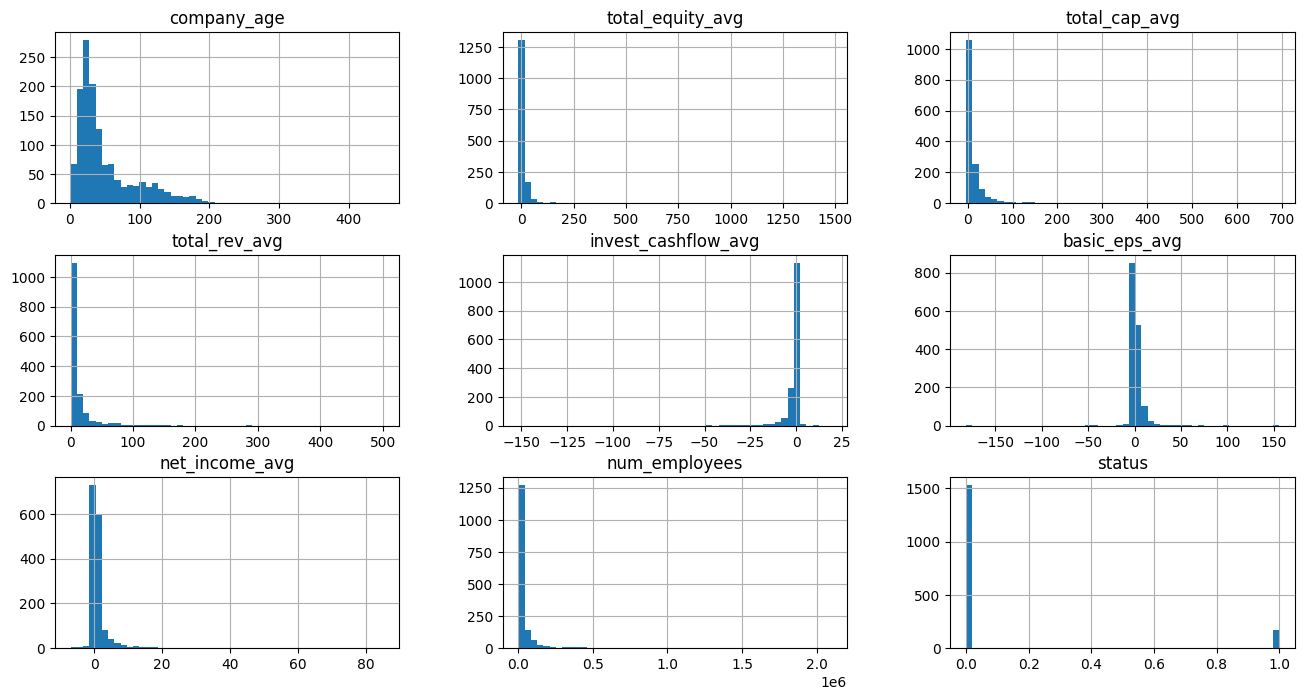

In [7]:
df.hist(bins=50, figsize=(16, 8))
plt.show()

<h4>Create dummies for categorical variables</h4>

In [8]:
# get dummy variables
industry_dummies = pd.get_dummies(
    df.industry.apply(pd.Series).stack()
).groupby(level=0).sum()

df = pd.concat([df, industry_dummies], axis=1)
df.head(1)

,country,company_age,total_equity_avg,total_cap_avg,total_rev_avg,invest_cashflow_avg,basic_eps_avg,net_income_avg,num_employees,industry,...,Food_Restaurants,Healthcare,IT_Software,Logistics_Transportation,Machinery_Manufacture,Resources_Materials,Retail_ECommerce,Services_Travel,Technology_Electronics,Transport_Aerospace
0,US,26.0,16.036998,30.823895,28.570429,-1.37229,8.571667,4.070609,12800.0,Communication_Entertainment,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# convert country to binary is_us
df.country = df.country == "US"
df = df.rename(columns={"country": "is_us"})
df.is_us = df.is_us.astype(int)
df.head(1)

,is_us,company_age,total_equity_avg,total_cap_avg,total_rev_avg,invest_cashflow_avg,basic_eps_avg,net_income_avg,num_employees,industry,...,Food_Restaurants,Healthcare,IT_Software,Logistics_Transportation,Machinery_Manufacture,Resources_Materials,Retail_ECommerce,Services_Travel,Technology_Electronics,Transport_Aerospace
0,1,26.0,16.036998,30.823895,28.570429,-1.37229,8.571667,4.070609,12800.0,Communication_Entertainment,...,0,0,0,0,0,0,0,0,0,0


<h3>Design matrix and multicolinearity</h3>

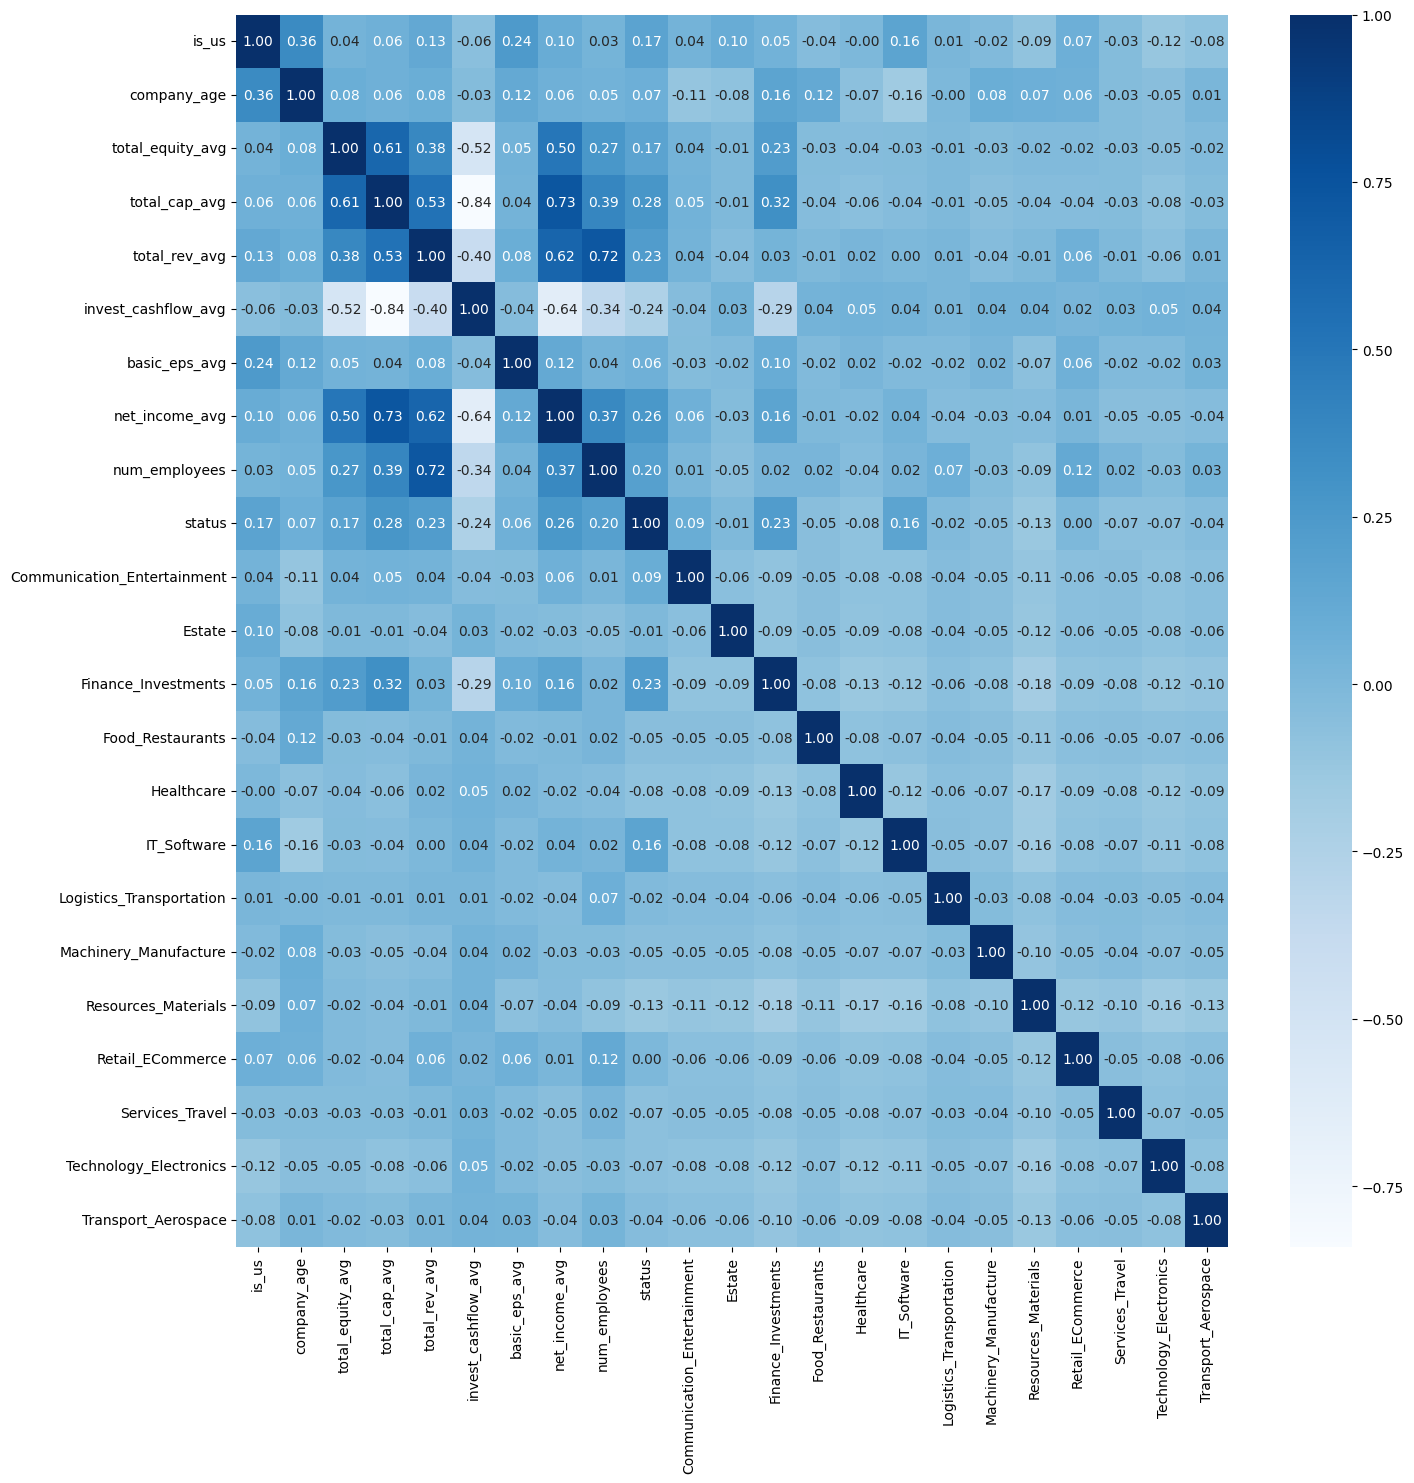

In [12]:
# correlation matrix

plt.figure(figsize=(16, 16))

sns.heatmap(
    df.corr(numeric_only=True).round(2),
    annot=True, fmt=".2f", cmap=plt.cm.Blues
)

plt.show()

In [13]:
# fill in all NAs in financial data with median
num_cols = [
    "company_age", "total_equity_avg",
    "total_cap_avg", "total_rev_avg", "invest_cashflow_avg",
    "basic_eps_avg", "net_income_avg", 
    "num_employees"
]

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

In [14]:
industries = df.industry.unique().tolist()

<h4>Create a scaled dataframe for classification</h4>

In [15]:
# regressor variables
reg_cols = num_cols.copy()

binary_cols = ["is_us"] + industries

reg_cols.extend(binary_cols)

df_scaled = df[reg_cols].copy()

# scale num_cols
df_scaled[num_cols] = (
    df_scaled[num_cols] - df_scaled[num_cols].mean(axis=0)
) / df_scaled[num_cols].std(axis=0, ddof=1)

# add status column
df_scaled["status"] = df["status"]

df_scaled.head(1)

,company_age,total_equity_avg,total_cap_avg,total_rev_avg,invest_cashflow_avg,basic_eps_avg,net_income_avg,num_employees,is_us,Communication_Entertainment,...,IT_Software,Retail_ECommerce,Technology_Electronics,Finance_Investments,Estate,Services_Travel,Transport_Aerospace,Machinery_Manufacture,Logistics_Transportation,status
0,-0.503826,0.104047,0.263435,0.440614,0.070342,0.771078,0.619374,-0.225154,1,1,...,0,0,0,0,0,0,0,0,0,0


<h3>PCA Plot of data</h3>

In [16]:
Xs = df_scaled[reg_cols].values
Y = df_scaled.status.values

In [17]:
from sklearn.decomposition import PCA

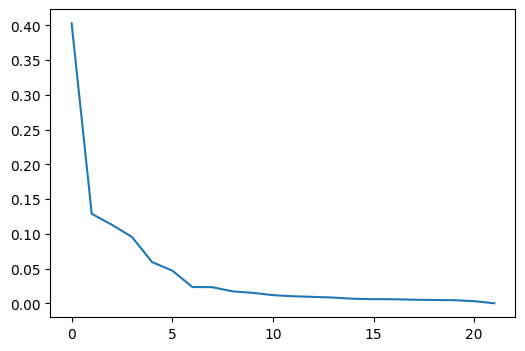

In [18]:
pca = PCA(n_components=Xs.shape[1])
PCA_res = pca.fit_transform(Xs)

plt.figure(figsize=(6, 4))
plt.plot(pca.explained_variance_ratio_)
plt.show()

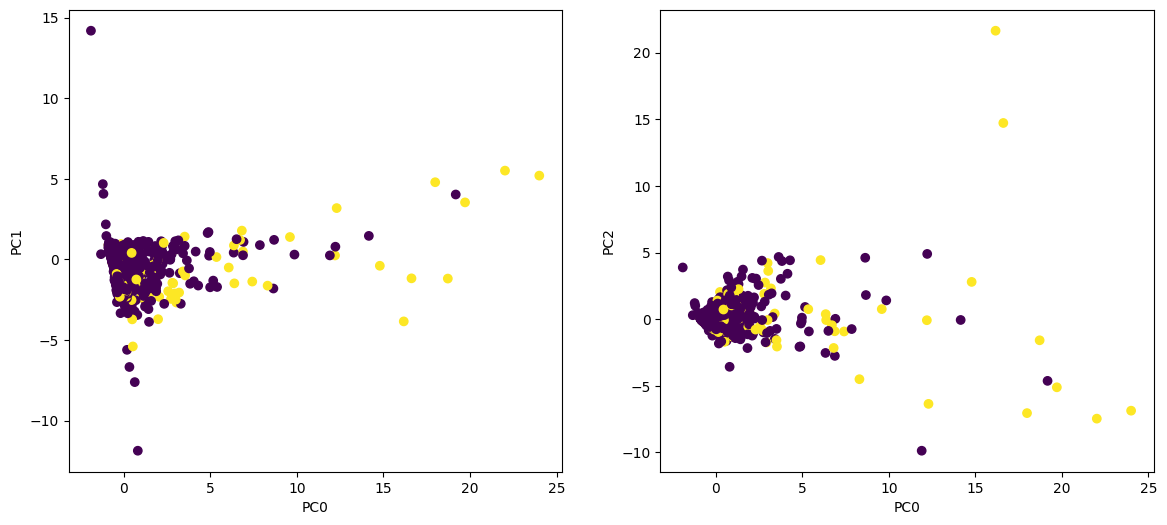

In [19]:
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121)
ax1.scatter(PCA_res[:, 0], PCA_res[:, 1], c=df.status)
ax1.set_xlabel("PC0")
ax1.set_ylabel("PC1")

ax2 = fig.add_subplot(122)
ax2.scatter(PCA_res[:, 0], PCA_res[:, 2], c=df.status)
ax2.set_xlabel("PC0")
ax2.set_ylabel("PC2")

plt.show()

<h2>Classification</h2>

In [20]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_score, 
    recall_score
)

<p>We will use 80-20 train test split. We will test the results of some models on test data itself. But of course we won't tune our models nor choose best models using test sample, we will use K-Fold crossvalidation for that. Since we have very few observations with blockchain=True, meaning our data is highly imbalanced, therefore, we do not want to chip off a validation set from training data nor have few data in both validation and test sets. Because all of this, we chose to do just train test split to preserve as much training data as possible</p>

In [21]:
df_train, df_test = train_test_split(
    df_scaled, train_size=0.8, stratify=df_scaled.status, random_state=42
)

<h4>Random classifier. Baseline model in imbalanced classification.</h4>

In [22]:
class RandomClassifier:
    
    def __init__(self):
        ...
    
    def predict(self, df_test: pd.DataFrame):
        class_0, class_1 = df_test.status.value_counts()
        p0 = class_0 / df_test.shape[0] # probability of picking a member of majority class
        return np.random.choice([0, 1], df_test.shape[0], p=[p0, 1-p0])
    
    def get_mean_precision_recall(
        self, df_test: pd.DataFrame, n_predictions=1000
    ) -> Dict[str, Any]:
        
        precisions, recalls = np.zeros(n_predictions), np.zeros(n_predictions)
        
        for i in tqdm(range(n_predictions)):
            y_pred = self.predict(df_test)
            precisions[i] = precision_score(df_test.status, y_pred, average=None)[1]
            recalls[i] = recall_score(df_test.status, y_pred, average=None)[1]
            
        return {
            "precision_mean": precisions.mean(axis=0),
            "recall_mean": recalls.mean(axis=0)
        }

In [23]:
rcls = RandomClassifier()
rcls.get_mean_precision_recall(df_test, n_predictions=3000)

100%|██████████████████████████████████████| 3000/3000 [00:16<00:00, 176.90it/s]


{'precision_mean': 0.09691773764449131, 'recall_mean': 0.09637373737373738}

In [24]:
class_0, class_1 = df_test.status.value_counts()
imbalance_ratio = class_1 / (class_0 + class_1)
print(f"Class imbalance ratio {imbalance_ratio}")

Class imbalance ratio 0.09705882352941177


<h3>Classification models</h3>

In [25]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

In [26]:
# returns a dictionary of numpy arrays with precision and recall scores for every threshold
# between 0 and 1
def calc_precision_recall_values(
    y_true: np.array, y_probs: np.array, n_thresholds=1000
) -> Dict[str, np.array]:
    
    df_pr = pd.DataFrame({
        "y_true": y_true, # actual value wheather blockchain is implemented or not
        "y_prob": y_probs, # probability predicted by the classification model
    })
    
    precision_scores, recall_scores = [], []
    thresholds = np.linspace(0, 1, n_thresholds) # define threshold for which precision and recall are calculated

    overall_negative, overall_positive = y_true.value_counts()
    
    for threshold in thresholds:
        df_pr["y_pred"] = (df_pr.y_prob > threshold).astype(int) # make a prediction based on prob threshold
        
        FP = ((df_pr["y_pred"]==1) & (df_pr["y_true"]==0)).sum()
        TP = ((df_pr["y_pred"]==1) & (df_pr["y_true"]==1)).sum()
        FN = ((df_pr["y_pred"]==0) & (df_pr["y_true"]==1)).sum()
        TN = ((df_pr["y_pred"]==0) & (df_pr["y_true"]==0)).sum()
        
        true_predictions = TP + FP
        
        precision_scores.append(
            TP / (TP + FP) if true_predictions > 0 else 1
        )
        recall_scores.append(TP / (TP + FN))
        
    return {
        "precisions": np.array(precision_scores), 
        "recalls": np.array(recall_scores)
    }

In [27]:
def plot_precision_recall_curves(
    model_res: Dict[str, Dict[str, np.array]],
    figsize: Tuple[int, int] = (8, 6)
) -> None:
    
    plt.figure(figsize=figsize)
    
    for model_name, res in model_res.items():
        auc_score = auc(res["recalls"], res["precisions"])
        plt.plot(
            res["recalls"], res["precisions"], 
            label=f"{model_name} PR-AUC: {round(auc_score, 3)}"
        )

    f_scores = np.linspace(0.2, 0.8, num=6)
    lines, labels = [], []

    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="blue", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    
    plt.title("Precision Recall Curve")
    
    plt.legend()
    plt.ylim([0.0, 1.05])

    return plt

<h3>Logistic Regression</h3>

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

<h4>Slightly adjusted Logistic Regression model</h4>

<p>Here we will just adjust the weights for imbalanced data, model is penalised greatly now if it wrongly classifies the minority class. Therefore, we should expect high recall score and low precision score.</p>

In [29]:
logr = LogisticRegression(
    max_iter=int(1e7),
    class_weight={0: 1, 1: 1 / imbalance_ratio}
)

logr.fit(df_train[reg_cols], df_train.status)

probs = logr.predict_proba(df_test[reg_cols])[:, 1]
y_pred = (probs >= 0.5).astype(int)

print(classification_report(df_test.status, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.69      0.81       307
           1       0.21      0.79      0.34        33

    accuracy                           0.70       340
   macro avg       0.59      0.74      0.57       340
weighted avg       0.89      0.70      0.76       340



In [30]:
res_logr = calc_precision_recall_values(df_test.status, probs, n_thresholds=1000)

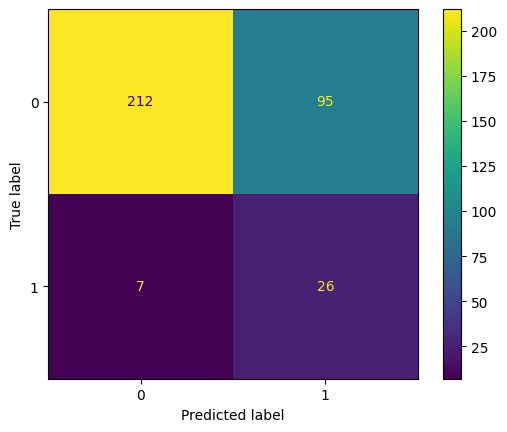

In [31]:
cm = confusion_matrix(df_test.status, y_pred)

ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=[0, 1]
).plot()

plt.savefig("confusion_matrix_1.png")

plt.show()

<p>As we can the model above has a very low f1-score of 0.25 for class 1 (has blockchain) which corresponds to low precision and recall scores. These are calculated from the confusion matrix above. From the confusion matrix we see that model has hard times correctly identifying class 1 observations. It has a lot of False Negatives (22), so it attempts to label everything as a majority class.</p>
<p>Out of 26 class 1 observations predictions the model was able to label only 4 correctly, this is shown by low recall score of $\frac{4}{22+4} = 0.15$. With such configuration model is not willing to risk and say True because it is better off saying No for the majority of observations. But when it is certain, labeling an observation as a minority it has a precision of $\frac{4}{2+4} = 0.66$ which is more or less ok.</p>

<h4>Precision-Recall Curve and AUC</h4>

<p>Using AUC (Area under the Precision-Recall Curve) will allow us to evaluate how good each specification of Logistic Regression performs at each threshold level (any probability threshold $p \in [0, 1]$</p>

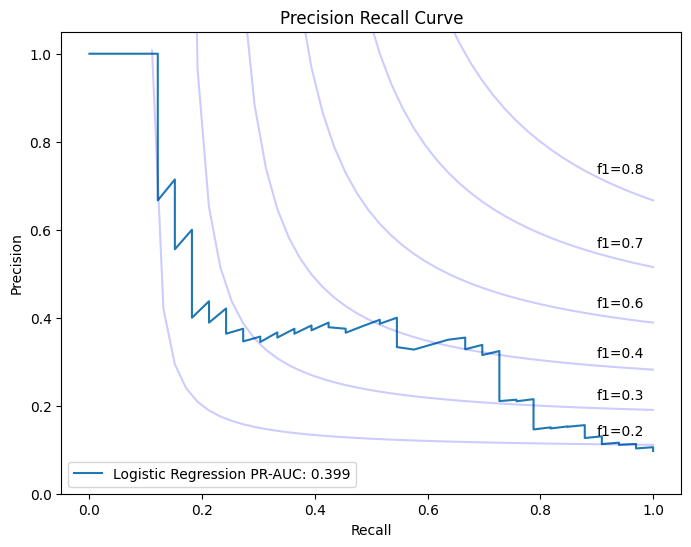

In [32]:
fig = plot_precision_recall_curves(
    model_res={
        "Logistic Regression": res_logr,
    }
)

fig.savefig("precision_recall_1.png")

fig.show()

<h4>Fine-tuning Logistic Regression</h4>

<p>In this section we will try our best to fine-tune hyperparameters of the Logistic Regression model. We will use K-Fold stratified cross-validation to evaluate fitness of our models. As a quality scoring metric we will go for average_precision_score which is more or less the same as Precision-Recall AUC, since it allows to evaluate overall model performance no matter the probability cut-off. Model with higher PR-AUC score performs on average better at every threshold level which is exactly what we are after</p>

<p>We will use mainly Bayseian optimisation <b>Optuna</b> for tuning our model</p>

In [33]:
import optuna

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve, auc

from functools import partial

In [34]:
fold = RepeatedStratifiedKFold(n_splits=6, n_repeats=2, random_state=42)

In [43]:
def objective_lr(trial, df: pd.DataFrame, fixed_params):
    # define parameter space for optuna to choose from
    l1_ratio = trial.suggest_float("l1_ratio", 0, 1)
    class_weight = {0: 1, 1: trial.suggest_float("class_weight", 1, 15)}
    
    logr = LogisticRegression(
        **fixed_params,
        class_weight=class_weight,
        l1_ratio=l1_ratio,
    )
    
    val_auc_scores, train_auc_scores = [], []
    
    for train_idx, val_idx in fold.split(df[reg_cols], df.status):
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # split data into train and validation then calculate target PR-AUC score
        logr.fit(df_train[reg_cols], df_train.status)
        # calculate PR-AUC score for both train and validation sets
        probs_train = logr.predict_proba(df_train[reg_cols])[:, 1]
        precisions, recalls, _ = precision_recall_curve(df_train.status, probs_train)
        train_auc_scores.append(
            auc(recalls, precisions)
        )
        
        probs_val = logr.predict_proba(df_val[reg_cols])[:, 1]
        precisions, recalls, _ = precision_recall_curve(df_val.status, probs_val)
        val_auc_scores.append(
            auc(recalls, precisions)
        )
        
    # update global variables
    logr_logs["train_auc"].append(train_auc_scores)
    logr_logs["val_auc"].append(val_auc_scores)
    
    return np.mean(val_auc_scores)

In [44]:
fixed_params = {
    "fit_intercept": True,
    "solver": "saga",
    "penalty": "elasticnet", # allows both LASSO and Ridge regularisation
    "max_iter": int(1e7), 
    "n_jobs": -1,
}

In [45]:
logr_logs = {
    "train_auc": [],
    "val_auc": []
}

study_lr = optuna.create_study(
    direction="maximize",
)

study_lr.optimize(
    partial(objective_lr, df=df_train, fixed_params=fixed_params), 
    n_trials=100
)

[I 2023-05-22 20:19:00,827] A new study created in memory with name: no-name-4aad1d86-d45c-4a17-81fc-d1441cf44329
[I 2023-05-22 20:19:04,773] Trial 0 finished with value: 0.3447255258148425 and parameters: {'l1_ratio': 0.3849547281362874, 'class_weight': 12.787674509615915}. Best is trial 0 with value: 0.3447255258148425.
[I 2023-05-22 20:19:08,070] Trial 1 finished with value: 0.3447455487056677 and parameters: {'l1_ratio': 0.2600245240015009, 'class_weight': 12.7063652306175}. Best is trial 1 with value: 0.3447455487056677.
[I 2023-05-22 20:19:11,685] Trial 2 finished with value: 0.3496068129202224 and parameters: {'l1_ratio': 0.7352251930941824, 'class_weight': 9.228254557407968}. Best is trial 2 with value: 0.3496068129202224.
[I 2023-05-22 20:19:14,551] Trial 3 finished with value: 0.3487714240670899 and parameters: {'l1_ratio': 0.325617265171778, 'class_weight': 7.221465845975522}. Best is trial 2 with value: 0.3496068129202224.
[I 2023-05-22 20:19:17,988] Trial 4 finished with v

[I 2023-05-22 20:21:51,789] Trial 36 finished with value: 0.36501371712691344 and parameters: {'l1_ratio': 0.5074226589567734, 'class_weight': 1.719350797237281}. Best is trial 15 with value: 0.36927903366261927.
[I 2023-05-22 20:21:55,923] Trial 37 finished with value: 0.35986043741083984 and parameters: {'l1_ratio': 0.7128319711282712, 'class_weight': 4.2925850414452285}. Best is trial 15 with value: 0.36927903366261927.
[I 2023-05-22 20:21:59,533] Trial 38 finished with value: 0.3533408939306961 and parameters: {'l1_ratio': 0.6355100147016076, 'class_weight': 7.122315696456029}. Best is trial 15 with value: 0.36927903366261927.
[I 2023-05-22 20:22:04,254] Trial 39 finished with value: 0.36859894272207105 and parameters: {'l1_ratio': 0.6118560776956387, 'class_weight': 1.013802800005213}. Best is trial 15 with value: 0.36927903366261927.
[I 2023-05-22 20:22:07,856] Trial 40 finished with value: 0.3630491553539516 and parameters: {'l1_ratio': 0.5988543089956174, 'class_weight': 2.9408

[I 2023-05-22 20:24:29,175] Trial 73 finished with value: 0.369707090411905 and parameters: {'l1_ratio': 0.8767677683183333, 'class_weight': 1.328371354912406}. Best is trial 70 with value: 0.37015033917999823.
[I 2023-05-22 20:24:34,079] Trial 74 finished with value: 0.36982994284477444 and parameters: {'l1_ratio': 0.8791910916917628, 'class_weight': 1.3894247322926905}. Best is trial 70 with value: 0.37015033917999823.
[I 2023-05-22 20:24:38,227] Trial 75 finished with value: 0.36753266647008814 and parameters: {'l1_ratio': 0.8768248218214904, 'class_weight': 2.4539175769198494}. Best is trial 70 with value: 0.37015033917999823.
[I 2023-05-22 20:24:42,979] Trial 76 finished with value: 0.3704464988940373 and parameters: {'l1_ratio': 0.9819667400945947, 'class_weight': 1.2792462195204894}. Best is trial 76 with value: 0.3704464988940373.
[I 2023-05-22 20:24:47,626] Trial 77 finished with value: 0.3703954466885319 and parameters: {'l1_ratio': 0.9999269089213946, 'class_weight': 1.34883

In [46]:
logr_tuned = LogisticRegression(
    **fixed_params, 
    l1_ratio=study_lr.best_params["l1_ratio"],
    class_weight={0: 1, 1: study_lr.best_params["class_weight"]}
)

# train tuned model 
logr_tuned.fit(df_train[reg_cols], df_train.status)
# predict probabilities of the minority class
probs = logr_tuned.predict_proba(df_test[reg_cols])[:, 1]

y_pred = logr_tuned.predict(df_test[reg_cols])

res_logr_tuned = calc_precision_recall_values(
    y_true=df_test.status, y_probs=probs
)

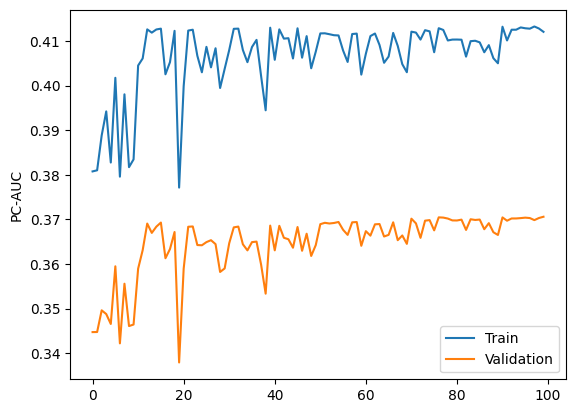

In [47]:
plt.plot(np.array(logr_logs["train_auc"]).mean(axis=1), label="Train")
plt.plot(np.array(logr_logs["val_auc"]).mean(axis=1), label="Validation")
plt.ylabel("PC-AUC")
plt.legend()
plt.show()

In [48]:
print(classification_report(df_test.status, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       307
           1       0.67      0.18      0.29        33

    accuracy                           0.91       340
   macro avg       0.79      0.59      0.62       340
weighted avg       0.89      0.91      0.89       340



<h3>Using Minority Oversampling to balance dataset</h3>

<h4>Random Oversampling</h4>

In [49]:
from imblearn.over_sampling import RandomOverSampler, SMOTENC, ADASYN

In [50]:
# oversample train set using random oversampling
def ros_oversampler(df: pd.DataFrame) -> pd.DataFrame:
    ros = RandomOverSampler(random_state=42)
    x_ros, y_ros = ros.fit_resample(df[reg_cols], df.status)
    return pd.concat([x_ros, y_ros], axis=1)

In [51]:
df_train_ros = ros_oversampler(df_train)
df_train_ros.status.value_counts()

0    1222
1    1222
Name: status, dtype: int64

In [52]:
def objective_lr_ros(trial, df: pd.DataFrame, fixed_params):
    # define parameter space for optuna to choose from
    
    logr = LogisticRegression(
        **fixed_params,
        l1_ratio=trial.suggest_float("l1_ratio", 0, 1),
        class_weight={0: 1, 1: trial.suggest_float("class_weight", 1, 15)}
    )
    
    val_auc_scores, train_auc_scores = [], []
    
    for train_idx, val_idx in fold.split(df[reg_cols], df.status):
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # copy minority class using Random oversampler
        df_train = ros_oversampler(df_train)
        # split data into train and validation then calculate target PR-AUC score
        logr.fit(df_train[reg_cols], df_train.status)
        # calculate PR-AUC score for both train and validation sets
        probs_train = logr.predict_proba(df_train[reg_cols])[:, 1]
        precisions, recalls, _ = precision_recall_curve(df_train.status, probs_train)
        train_auc_scores.append(
            auc(recalls, precisions)
        )
        
        probs_val = logr.predict_proba(df_val[reg_cols])[:, 1]
        precisions, recalls, _ = precision_recall_curve(df_val.status, probs_val)
        val_auc_scores.append(
            auc(recalls, precisions)
        )
        
    # update global variables
    logr_logs_ros["train_auc"].append(train_auc_scores)
    logr_logs_ros["val_auc"].append(val_auc_scores)
    
    return np.mean(val_auc_scores)

In [53]:
logr_logs_ros = {
    "train_auc": [],
    "val_auc": []
}

study_lr_ros = optuna.create_study(
    direction="maximize",
)

study_lr_ros.optimize(
    partial(objective_lr_ros, df=df_train, fixed_params=fixed_params), 
    n_trials=100
)

[I 2023-05-22 20:27:00,811] A new study created in memory with name: no-name-6521d90a-26f9-4f16-961c-614724539c14
[I 2023-05-22 20:27:05,317] Trial 0 finished with value: 0.330550380303495 and parameters: {'l1_ratio': 0.2515879284946082, 'class_weight': 4.793334587615799}. Best is trial 0 with value: 0.330550380303495.
[I 2023-05-22 20:27:11,720] Trial 1 finished with value: 0.31868063655187073 and parameters: {'l1_ratio': 0.7597202974528856, 'class_weight': 11.865249667888238}. Best is trial 0 with value: 0.330550380303495.
[I 2023-05-22 20:27:18,942] Trial 2 finished with value: 0.3230648913006654 and parameters: {'l1_ratio': 0.841936514712424, 'class_weight': 7.832501332236625}. Best is trial 0 with value: 0.330550380303495.
[I 2023-05-22 20:27:23,485] Trial 3 finished with value: 0.3353720418751944 and parameters: {'l1_ratio': 0.22071836819937396, 'class_weight': 2.293581783576365}. Best is trial 3 with value: 0.3353720418751944.
[I 2023-05-22 20:27:27,849] Trial 4 finished with va

[I 2023-05-22 20:30:47,326] Trial 37 finished with value: 0.3469358904403686 and parameters: {'l1_ratio': 0.616789365690831, 'class_weight': 1.022812426538344}. Best is trial 31 with value: 0.3469933003713172.
[I 2023-05-22 20:30:56,455] Trial 38 finished with value: 0.33586033228748025 and parameters: {'l1_ratio': 0.6728724264465551, 'class_weight': 2.0428181299410295}. Best is trial 31 with value: 0.3469933003713172.
[I 2023-05-22 20:31:04,257] Trial 39 finished with value: 0.32571431041100946 and parameters: {'l1_ratio': 0.5905203917799136, 'class_weight': 7.0105716883076505}. Best is trial 31 with value: 0.3469933003713172.
[I 2023-05-22 20:31:12,931] Trial 40 finished with value: 0.32923306761954063 and parameters: {'l1_ratio': 0.8130308353189026, 'class_weight': 5.1971744215928215}. Best is trial 31 with value: 0.3469933003713172.
[I 2023-05-22 20:31:20,316] Trial 41 finished with value: 0.34684139180397816 and parameters: {'l1_ratio': 0.6295930337533648, 'class_weight': 1.030622

[I 2023-05-22 20:35:39,022] Trial 74 finished with value: 0.348277757684883 and parameters: {'l1_ratio': 0.4506261246468609, 'class_weight': 1.0090250148615993}. Best is trial 71 with value: 0.3488853758652242.
[I 2023-05-22 20:35:45,565] Trial 75 finished with value: 0.33734264636580397 and parameters: {'l1_ratio': 0.4309766483791566, 'class_weight': 2.379525159037461}. Best is trial 71 with value: 0.3488853758652242.
[I 2023-05-22 20:35:52,419] Trial 76 finished with value: 0.3401600712459845 and parameters: {'l1_ratio': 0.4589772749115863, 'class_weight': 1.3914408156150906}. Best is trial 71 with value: 0.3488853758652242.
[I 2023-05-22 20:35:59,189] Trial 77 finished with value: 0.3360665165970009 and parameters: {'l1_ratio': 0.490810655171419, 'class_weight': 1.875960379976962}. Best is trial 71 with value: 0.3488853758652242.
[I 2023-05-22 20:36:08,593] Trial 78 finished with value: 0.34691100714985895 and parameters: {'l1_ratio': 0.5067861808141497, 'class_weight': 1.0130017826

In [54]:
logr_ros_tuned = LogisticRegression(
    **fixed_params, 
    l1_ratio=study_lr_ros.best_params["l1_ratio"],
    class_weight={0: 1, 1: study_lr_ros.best_params["class_weight"]}
)

# train tuned model 
logr_ros_tuned.fit(df_train_ros[reg_cols], df_train_ros.status)
# predict probabilities of the minority class
probs = logr_ros_tuned.predict_proba(df_test[reg_cols])[:, 1]

res_logr_ros_tuned = calc_precision_recall_values(
    y_true=df_test.status, y_probs=probs
)

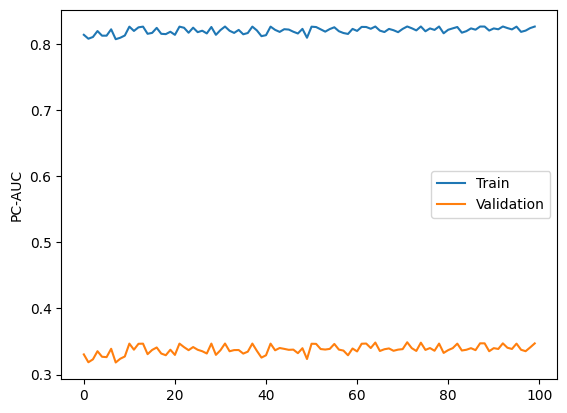

In [55]:
plt.plot(np.array(logr_logs_ros["train_auc"]).mean(axis=1), label="Train")
plt.plot(np.array(logr_logs_ros["val_auc"]).mean(axis=1), label="Validation")
plt.ylabel("PC-AUC")
plt.legend()
plt.show()

<h4>SMOTENC Oversampling</h4>

In [56]:
binary_cols_idx = []

for col in binary_cols:
    binary_cols_idx.append(
        reg_cols.index(col)
    )

binary_cols_idx

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [57]:
def smotenc_oversampler(df: pd.DataFrame) -> pd.DataFrame:
    sm = SMOTENC(
        random_state=42, 
        categorical_features=binary_cols_idx,
        k_neighbors=10
    )
    x_smotenc, y_smotenc = sm.fit_resample(df[reg_cols], df.status)
    return pd.concat([x_smotenc, y_smotenc], axis=1)

In [58]:
df_train_smotenc = smotenc_oversampler(df_train)

In [59]:
def objective_lr_smotenc(trial, df: pd.DataFrame, fixed_params):
    # define parameter space for optuna to choose from
    
    logr = LogisticRegression(
        **fixed_params,
        l1_ratio=trial.suggest_float("l1_ratio", 0, 1),
        class_weight={0: 1, 1: trial.suggest_float("class_weight", 1, 15)}
    )
    
    val_auc_scores, train_auc_scores = [], []
    
    for train_idx, val_idx in fold.split(df[reg_cols], df.status):
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # copy minority class using Random oversampler
        df_train = smotenc_oversampler(df_train)
        # split data into train and validation then calculate target PR-AUC score
        logr.fit(df_train[reg_cols], df_train.status)
        # calculate PR-AUC score for both train and validation sets
        probs_train = logr.predict_proba(df_train[reg_cols])[:, 1]
        precisions, recalls, _ = precision_recall_curve(df_train.status, probs_train)
        train_auc_scores.append(
            auc(recalls, precisions)
        )
        
        probs_val = logr.predict_proba(df_val[reg_cols])[:, 1]
        precisions, recalls, _ = precision_recall_curve(df_val.status, probs_val)
        val_auc_scores.append(
            auc(recalls, precisions)
        )
        
    # update global variables
    logr_logs_smote["train_auc"].append(train_auc_scores)
    logr_logs_smote["val_auc"].append(val_auc_scores)
    
    return np.mean(val_auc_scores)

In [60]:
logr_logs_smote = {
    "train_auc": [],
    "val_auc": []
}

study_lr_smotenc = optuna.create_study(
    direction="maximize",
)

study_lr_smotenc.optimize(
    partial(objective_lr_smotenc, df=df_train, fixed_params=fixed_params), 
    n_trials=100
)

[I 2023-05-22 21:08:06,725] A new study created in memory with name: no-name-9ca20e17-267a-4fd8-94b5-86bce593df0d
[I 2023-05-22 21:08:17,761] Trial 0 finished with value: 0.35821827272364093 and parameters: {'l1_ratio': 0.3891185775712863, 'class_weight': 11.969002273543781}. Best is trial 0 with value: 0.35821827272364093.
[I 2023-05-22 21:08:26,785] Trial 1 finished with value: 0.36712929828126656 and parameters: {'l1_ratio': 0.06723512896071682, 'class_weight': 2.2380513512095384}. Best is trial 1 with value: 0.36712929828126656.
[I 2023-05-22 21:08:36,240] Trial 2 finished with value: 0.3607238336213299 and parameters: {'l1_ratio': 0.4619045895402849, 'class_weight': 8.084898363379533}. Best is trial 1 with value: 0.36712929828126656.
[I 2023-05-22 21:08:47,634] Trial 3 finished with value: 0.35909171873991635 and parameters: {'l1_ratio': 0.8130930171994437, 'class_weight': 9.035421937508133}. Best is trial 1 with value: 0.36712929828126656.
[I 2023-05-22 21:08:59,700] Trial 4 fini

[I 2023-05-22 21:15:27,842] Trial 36 finished with value: 0.3673992440644844 and parameters: {'l1_ratio': 0.2657683335206886, 'class_weight': 2.3153739882026136}. Best is trial 24 with value: 0.37054762029821203.
[I 2023-05-22 21:15:39,066] Trial 37 finished with value: 0.36711847762019145 and parameters: {'l1_ratio': 0.11390936303899367, 'class_weight': 2.227285844854712}. Best is trial 24 with value: 0.37054762029821203.
[I 2023-05-22 21:15:49,886] Trial 38 finished with value: 0.3570103712033395 and parameters: {'l1_ratio': 0.18574738329665275, 'class_weight': 10.457060909333833}. Best is trial 24 with value: 0.37054762029821203.
[I 2023-05-22 21:16:02,659] Trial 39 finished with value: 0.3671870707698222 and parameters: {'l1_ratio': 0.04614753569557163, 'class_weight': 3.459764145359556}. Best is trial 24 with value: 0.37054762029821203.
[I 2023-05-22 21:16:13,255] Trial 40 finished with value: 0.36675309315304677 and parameters: {'l1_ratio': 0.10031562245272524, 'class_weight': 2.

[I 2023-05-22 21:24:00,870] Trial 73 finished with value: 0.37058823679075714 and parameters: {'l1_ratio': 0.1672470072991466, 'class_weight': 1.3522819555071344}. Best is trial 73 with value: 0.37058823679075714.
[I 2023-05-22 21:24:17,544] Trial 74 finished with value: 0.3674918231478193 and parameters: {'l1_ratio': 0.07882237954695884, 'class_weight': 2.452874741365667}. Best is trial 73 with value: 0.37058823679075714.
[I 2023-05-22 21:24:31,809] Trial 75 finished with value: 0.36718241998077367 and parameters: {'l1_ratio': 0.023588840585128577, 'class_weight': 1.9372710575126448}. Best is trial 73 with value: 0.37058823679075714.
[I 2023-05-22 21:24:46,186] Trial 76 finished with value: 0.3687894151049105 and parameters: {'l1_ratio': 0.17417042794294216, 'class_weight': 1.242793855032472}. Best is trial 73 with value: 0.37058823679075714.
[I 2023-05-22 21:24:59,092] Trial 77 finished with value: 0.36698491483043433 and parameters: {'l1_ratio': 0.06257586443961591, 'class_weight': 

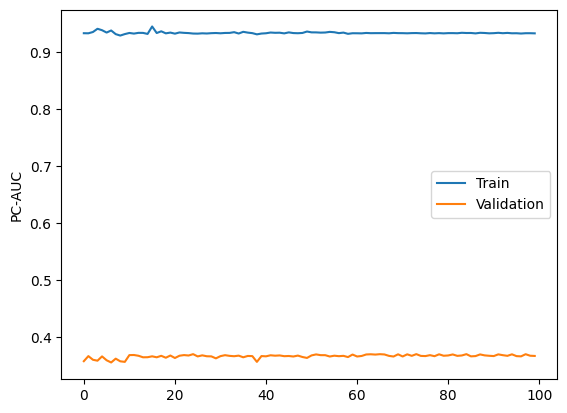

In [61]:
plt.plot(np.array(logr_logs_smote["train_auc"]).mean(axis=1), label="Train")
plt.plot(np.array(logr_logs_smote["val_auc"]).mean(axis=1), label="Validation")
plt.ylabel("PC-AUC")
plt.legend()
plt.show()

In [62]:
logr_smotenc_tuned = LogisticRegression(
    **fixed_params, 
    l1_ratio=study_lr_smotenc.best_params["l1_ratio"],
    class_weight={0: 1, 1: study_lr_smotenc.best_params["class_weight"]}
)
# train tuned model 
logr_smotenc_tuned.fit(df_train_smotenc[reg_cols], df_train_smotenc.status)
y_pred = logr_smotenc_tuned.predict(df_test[reg_cols])
# predict probabilities of the minority class
probs = logr_smotenc_tuned.predict_proba(df_test[reg_cols])[:, 1]

res_logr_smotenc_tuned = calc_precision_recall_values(
    y_true=df_test.status, y_probs=probs
)

In [63]:
print(classification_report(df_test.status, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.80      0.87       307
           1       0.27      0.67      0.38        33

    accuracy                           0.79       340
   macro avg       0.61      0.73      0.63       340
weighted avg       0.89      0.79      0.82       340



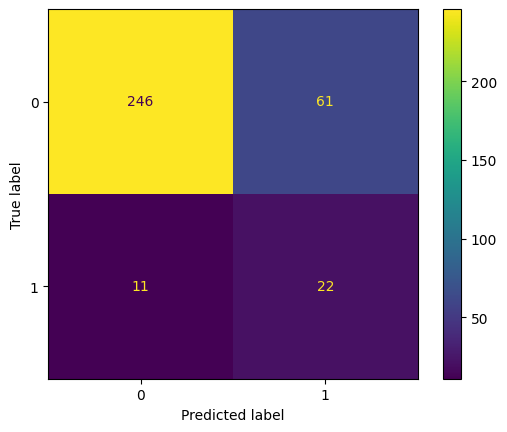

In [64]:
plt.style.use("default")

cm = confusion_matrix(df_test.status, y_pred)

ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=logr_smotenc_tuned.classes_,
).plot()

plt.show()

In [65]:
from sklearn.metrics import precision_recall_curve, auc, PrecisionRecallDisplay

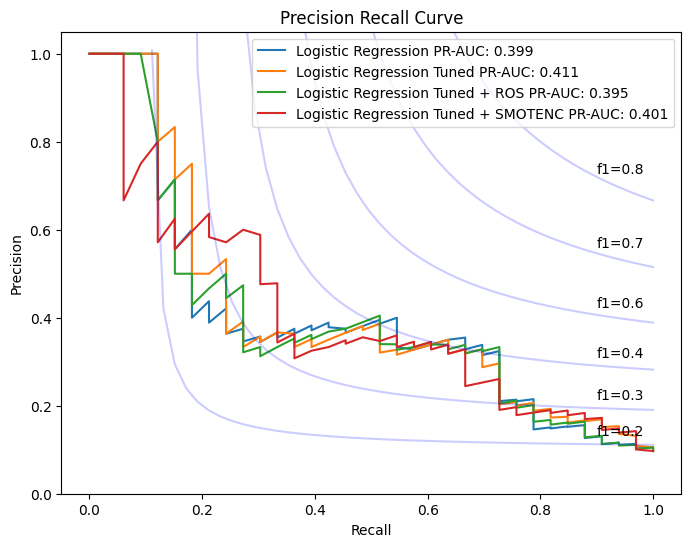

In [66]:
fig = plot_precision_recall_curves(
    model_res={
        "Logistic Regression": res_logr,
        "Logistic Regression Tuned": res_logr_tuned,
        "Logistic Regression Tuned + ROS": res_logr_ros_tuned,
        "Logistic Regression Tuned + SMOTENC": res_logr_smotenc_tuned,
   }
)

fig.savefig("logistic_regressions.png")

<h3>Random Forest Classifier</h3>

In [67]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
def objective_rf(trial, df: pd.DataFrame, fixed_params):

    rf = RandomForestClassifier(
         # max depth of grown trees, (it is typically better to have more of smaller trees so there is no overfit)
        max_depth=trial.suggest_int("max_depth", 2, 5),
        # number of trees grown in our ensemble
        n_estimators=trial.suggest_int("n_estimators", 100, 500),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 15),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 2, 15),
        min_impurity_decrease=trial.suggest_float("min_impurity_decrease", 0, 0.01),
        max_samples=trial.suggest_float("max_samples", 0.5, 1), # use not all observations to avoid overfit
        **fixed_params
    )
    
    val_auc_scores, train_auc_scores = [], []
    
    for train_idx, val_idx in fold.split(df[reg_cols], df.status):
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # split data into train and validation then calculate target PR-AUC score
        rf.fit(df_train[reg_cols], df_train.status)
        # calculate PR-AUC score for both train and validation sets
        probs_train = rf.predict_proba(df_train[reg_cols])[:, 1]
        precisions, recalls, _ = precision_recall_curve(df_train.status, probs_train)
        train_auc_scores.append(
            auc(recalls, precisions)
        )
        
        probs_val = rf.predict_proba(df_val[reg_cols])[:, 1]
        precisions, recalls, _ = precision_recall_curve(df_val.status, probs_val)
        val_auc_scores.append(
            auc(recalls, precisions)
        )
        
    # update global variables
    rf_logs["train_auc"].append(train_auc_scores)
    rf_logs["val_auc"].append(val_auc_scores)
    
    return np.mean(val_auc_scores)

In [69]:
rf_logs = {
    "train_auc": [],
    "val_auc": []
}

fixed_params = {
    "criterion": "gini",
    "max_features": "sqrt",
    "class_weight": "balanced"
}

study_rf = optuna.create_study(
    direction="maximize",
)

study_rf.optimize(
    partial(objective_rf, df=df_train, fixed_params=fixed_params), 
    n_trials=100
)

[I 2023-05-22 21:30:23,668] A new study created in memory with name: no-name-ccd6bccc-a641-4339-b7c1-3baf1c230ad1
[I 2023-05-22 21:30:32,420] Trial 0 finished with value: 0.3380963882192171 and parameters: {'max_depth': 3, 'n_estimators': 204, 'min_samples_split': 3, 'min_samples_leaf': 13, 'min_impurity_decrease': 0.004634796437719235, 'max_samples': 0.9831043083806434}. Best is trial 0 with value: 0.3380963882192171.
[I 2023-05-22 21:30:37,508] Trial 1 finished with value: 0.32716811430656006 and parameters: {'max_depth': 2, 'n_estimators': 142, 'min_samples_split': 13, 'min_samples_leaf': 12, 'min_impurity_decrease': 0.0019239363815544586, 'max_samples': 0.865514110356638}. Best is trial 0 with value: 0.3380963882192171.
[I 2023-05-22 21:30:44,431] Trial 2 finished with value: 0.33311735853089025 and parameters: {'max_depth': 2, 'n_estimators': 198, 'min_samples_split': 11, 'min_samples_leaf': 12, 'min_impurity_decrease': 0.006296528660111779, 'max_samples': 0.5461030763640502}. Bes

[I 2023-05-22 21:35:06,085] Trial 25 finished with value: 0.33657876413195836 and parameters: {'max_depth': 3, 'n_estimators': 454, 'min_samples_split': 5, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0014404371012377562, 'max_samples': 0.9046877794730079}. Best is trial 16 with value: 0.3454264233109656.
[I 2023-05-22 21:35:15,562] Trial 26 finished with value: 0.3452800733518964 and parameters: {'max_depth': 4, 'n_estimators': 309, 'min_samples_split': 9, 'min_samples_leaf': 7, 'min_impurity_decrease': 0.0018274224923621977, 'max_samples': 0.8560296439287207}. Best is trial 16 with value: 0.3454264233109656.
[I 2023-05-22 21:35:24,101] Trial 27 finished with value: 0.3435707123403278 and parameters: {'max_depth': 5, 'n_estimators': 296, 'min_samples_split': 7, 'min_samples_leaf': 7, 'min_impurity_decrease': 0.0017302317459216977, 'max_samples': 0.7403045988324086}. Best is trial 16 with value: 0.3454264233109656.
[I 2023-05-22 21:35:33,624] Trial 28 finished with value: 0.343362

[I 2023-05-22 21:39:06,385] Trial 51 finished with value: 0.34361438081437096 and parameters: {'max_depth': 4, 'n_estimators': 416, 'min_samples_split': 7, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0007911576231824979, 'max_samples': 0.9417446795765403}. Best is trial 41 with value: 0.3474671321627995.
[I 2023-05-22 21:39:15,519] Trial 52 finished with value: 0.34569434691156914 and parameters: {'max_depth': 4, 'n_estimators': 326, 'min_samples_split': 8, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.0014229311656181877, 'max_samples': 0.9616962090754461}. Best is trial 41 with value: 0.3474671321627995.
[I 2023-05-22 21:39:24,576] Trial 53 finished with value: 0.3418749162102199 and parameters: {'max_depth': 4, 'n_estimators': 321, 'min_samples_split': 8, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.0014275920771684206, 'max_samples': 0.9710233811409645}. Best is trial 41 with value: 0.3474671321627995.
[I 2023-05-22 21:39:34,027] Trial 54 finished with value: 0.34552

[I 2023-05-22 21:44:53,624] Trial 77 finished with value: 0.34578879417732566 and parameters: {'max_depth': 5, 'n_estimators': 420, 'min_samples_split': 2, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.0003511022545693104, 'max_samples': 0.9298553203946893}. Best is trial 55 with value: 0.35007199798667127.
[I 2023-05-22 21:45:00,649] Trial 78 finished with value: 0.3359503355265436 and parameters: {'max_depth': 4, 'n_estimators': 225, 'min_samples_split': 4, 'min_samples_leaf': 9, 'min_impurity_decrease': 0.0006038374504518773, 'max_samples': 0.9097463693150177}. Best is trial 55 with value: 0.35007199798667127.
[I 2023-05-22 21:45:08,342] Trial 79 finished with value: 0.34563923034862004 and parameters: {'max_depth': 5, 'n_estimators': 253, 'min_samples_split': 5, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.0013341570067343434, 'max_samples': 0.8839362050117561}. Best is trial 55 with value: 0.35007199798667127.
[I 2023-05-22 21:45:23,178] Trial 80 finished with value: 0.

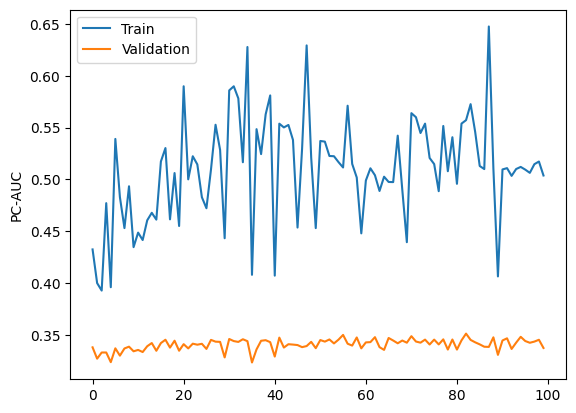

In [70]:
plt.plot(np.array(rf_logs["train_auc"]).mean(axis=1), label="Train")
plt.plot(np.array(rf_logs["val_auc"]).mean(axis=1), label="Validation")
plt.ylabel("PC-AUC")

plt.legend()
plt.show()

In [71]:
rf_tuned = RandomForestClassifier(**fixed_params, **study_rf.best_params)
# train tuned model 
rf_tuned.fit(df_train[reg_cols], df_train.status)
# predict probabilities of the minority class
probs = rf_tuned.predict_proba(df_test[reg_cols])[:, 1]
y_pred = rf_tuned.predict(df_test[reg_cols])

res_rf_tuned = calc_precision_recall_values(
    y_true=df_test.status, y_probs=probs
)

<h4>Random Forest + SMOTE</h4>

In [72]:
def objective_rf_smotenc(trial, df: pd.DataFrame, fixed_params):
    # define parameter space for optuna to choose from
    rf = RandomForestClassifier(
         # max depth of grown trees, (it is typically better to have more of smaller trees so there is no overfit)
        max_depth=trial.suggest_int("max_depth", 2, 5),
        # number of trees grown in our ensemble
        n_estimators=trial.suggest_int("n_estimators", 100, 500),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 15),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 2, 15),
        min_impurity_decrease=trial.suggest_float("min_impurity_decrease", 0, 0.01),
        max_samples=trial.suggest_float("max_samples", 0.5, 1), # use not all observations to avoid overfit
        **fixed_params
    )
    
    val_auc_scores, train_auc_scores = [], []
    
    for train_idx, val_idx in fold.split(df[reg_cols], df.status):
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # copy minority class using Random oversampler
        df_train = smotenc_oversampler(df_train)
        # split data into train and validation then calculate target PR-AUC score
        rf.fit(df_train[reg_cols], df_train.status)
        # calculate PR-AUC score for both train and validation sets
        probs_train = rf.predict_proba(df_train[reg_cols])[:, 1]
        precisions, recalls, _ = precision_recall_curve(df_train.status, probs_train)
        train_auc_scores.append(
            auc(recalls, precisions)
        )
        
        probs_val = rf.predict_proba(df_val[reg_cols])[:, 1]
        precisions, recalls, _ = precision_recall_curve(df_val.status, probs_val)
        val_auc_scores.append(
            auc(recalls, precisions)
        )
        
    # update global variables
    rf_smotenc_logs["train_auc"].append(train_auc_scores)
    rf_smotenc_logs["val_auc"].append(val_auc_scores)
    
    return np.mean(val_auc_scores)

In [73]:
rf_smotenc_logs = {
    "train_auc": [],
    "val_auc": []
}

study_rf_smotenc = optuna.create_study(
    direction="maximize",
)

study_rf_smotenc.optimize(
    partial(objective_rf_smotenc, df=df_train, fixed_params=fixed_params), 
    n_trials=100
)

[I 2023-05-22 21:49:50,225] A new study created in memory with name: no-name-4da60f64-69f0-4278-a077-54244bd6276e
[I 2023-05-22 21:50:13,441] Trial 0 finished with value: 0.31073844629229586 and parameters: {'max_depth': 2, 'n_estimators': 468, 'min_samples_split': 2, 'min_samples_leaf': 7, 'min_impurity_decrease': 0.004809041663868586, 'max_samples': 0.954580030673656}. Best is trial 0 with value: 0.31073844629229586.
[I 2023-05-22 21:50:23,921] Trial 1 finished with value: 0.32672489647615927 and parameters: {'max_depth': 5, 'n_estimators': 100, 'min_samples_split': 11, 'min_samples_leaf': 7, 'min_impurity_decrease': 0.005854956599915626, 'max_samples': 0.7771387248995587}. Best is trial 1 with value: 0.32672489647615927.
[I 2023-05-22 21:50:49,233] Trial 2 finished with value: 0.32120824645267404 and parameters: {'max_depth': 5, 'n_estimators': 456, 'min_samples_split': 12, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0081532767877908, 'max_samples': 0.7077778890027924}. Best i

[I 2023-05-22 21:57:36,379] Trial 25 finished with value: 0.31998907973888596 and parameters: {'max_depth': 5, 'n_estimators': 255, 'min_samples_split': 8, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.002608954983068215, 'max_samples': 0.6828219801358353}. Best is trial 9 with value: 0.33106014423875624.
[I 2023-05-22 21:57:57,183] Trial 26 finished with value: 0.3206220962469981 and parameters: {'max_depth': 3, 'n_estimators': 342, 'min_samples_split': 2, 'min_samples_leaf': 13, 'min_impurity_decrease': 0.004443977739372218, 'max_samples': 0.5819224283456694}. Best is trial 9 with value: 0.33106014423875624.
[I 2023-05-22 21:58:15,990] Trial 27 finished with value: 0.32347213109485834 and parameters: {'max_depth': 4, 'n_estimators': 217, 'min_samples_split': 13, 'min_samples_leaf': 11, 'min_impurity_decrease': 0.001826626335889996, 'max_samples': 0.634928255699843}. Best is trial 9 with value: 0.33106014423875624.
[I 2023-05-22 21:58:28,144] Trial 28 finished with value: 0.324966

[I 2023-05-22 22:08:08,550] Trial 51 finished with value: 0.3349577714382322 and parameters: {'max_depth': 5, 'n_estimators': 462, 'min_samples_split': 5, 'min_samples_leaf': 9, 'min_impurity_decrease': 0.0023702729105518306, 'max_samples': 0.6547830224829476}. Best is trial 51 with value: 0.3349577714382322.
[I 2023-05-22 22:08:31,205] Trial 52 finished with value: 0.32880247141032576 and parameters: {'max_depth': 5, 'n_estimators': 452, 'min_samples_split': 5, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.0015553174540389484, 'max_samples': 0.6405424176977277}. Best is trial 51 with value: 0.3349577714382322.
[I 2023-05-22 22:08:59,507] Trial 53 finished with value: 0.3253511924632211 and parameters: {'max_depth': 5, 'n_estimators': 477, 'min_samples_split': 6, 'min_samples_leaf': 11, 'min_impurity_decrease': 0.002269882792546396, 'max_samples': 0.6665419728382584}. Best is trial 51 with value: 0.3349577714382322.
[I 2023-05-22 22:09:10,411] Trial 54 finished with value: 0.32548

[I 2023-05-22 22:20:02,274] Trial 77 finished with value: 0.3264715246764268 and parameters: {'max_depth': 5, 'n_estimators': 458, 'min_samples_split': 10, 'min_samples_leaf': 12, 'min_impurity_decrease': 0.0030651413086421764, 'max_samples': 0.6594236981631291}. Best is trial 51 with value: 0.3349577714382322.
[I 2023-05-22 22:20:40,163] Trial 78 finished with value: 0.3296228943971024 and parameters: {'max_depth': 5, 'n_estimators': 475, 'min_samples_split': 12, 'min_samples_leaf': 13, 'min_impurity_decrease': 0.002057245247258736, 'max_samples': 0.6009197123566339}. Best is trial 51 with value: 0.3349577714382322.
[I 2023-05-22 22:21:08,489] Trial 79 finished with value: 0.3252168858949459 and parameters: {'max_depth': 5, 'n_estimators': 489, 'min_samples_split': 9, 'min_samples_leaf': 14, 'min_impurity_decrease': 0.0016782069896035638, 'max_samples': 0.677427573425666}. Best is trial 51 with value: 0.3349577714382322.
[I 2023-05-22 22:21:28,401] Trial 80 finished with value: 0.3217

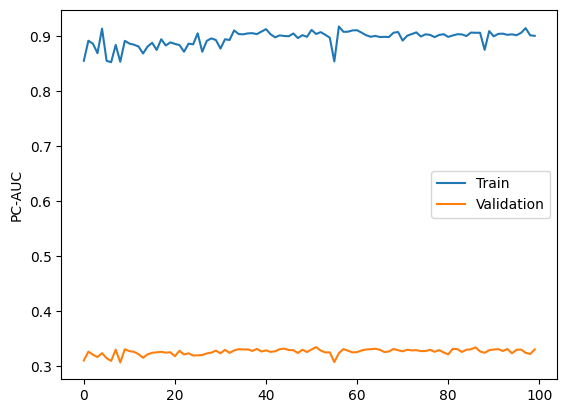

In [74]:
plt.plot(np.array(rf_smotenc_logs["train_auc"]).mean(axis=1), label="Train")
plt.plot(np.array(rf_smotenc_logs["val_auc"]).mean(axis=1), label="Validation")
plt.ylabel("PC-AUC")
plt.legend()
plt.show()

In [75]:
rf_smotenc_tuned = RandomForestClassifier(**fixed_params, **study_rf_smotenc.best_params)
# train tuned model 
rf_smotenc_tuned.fit(df_train_smotenc[reg_cols], df_train_smotenc.status)
# predict probabilities of the minority class
probs = rf_smotenc_tuned.predict_proba(df_test[reg_cols])[:, 1]
y_pred = rf_smotenc_tuned.predict(df_test[reg_cols])

res_rf_smotenc_tuned = calc_precision_recall_values(
    y_true=df_test.status, y_probs=probs
)

<h3>Gradient boosting with XGBoost</h3>

In [76]:
import xgboost as xgb

from optuna.visualization.matplotlib import plot_param_importances, plot_contour

plt.style.use("default")

In [77]:
def objective_xgboost(trial, df: pd.DataFrame):
    
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.00001, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.00001, 0.1, log=True),
        "eval_metric": "aucpr",
        "objective": "binary:logistic",
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "gamma": trial.suggest_float("gamma", 0.01, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0, 1),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 2),
    }
    
    train = xgb.DMatrix(df[reg_cols], label=df.status)
    
    cv_results = xgb.cv(
        params, 
        train, 
        num_boost_round=1000, 
        nfold=8, stratified=True, shuffle=True, early_stopping_rounds=10, 
        seed=42
    )
    
    logs_xgboost["train_auc"].append(cv_results["train-aucpr-mean"].values)
    logs_xgboost["val_auc"].append(cv_results["test-aucpr-mean"].values)
    
    return cv_results['test-aucpr-mean'].iloc[-1]

In [78]:
logs_xgboost = {
    "train_auc": [],
    "val_auc": []
}

study_xgboost = optuna.create_study(
    direction="maximize",
)

study_xgboost.optimize(
    partial(objective_xgboost, df=df_train), 
    n_trials=1000
)

[I 2023-05-22 22:29:17,712] A new study created in memory with name: no-name-85445e0f-ec1c-4f00-ba6c-01040e4891d7
[I 2023-05-22 22:29:18,265] Trial 0 finished with value: 0.3225411991150609 and parameters: {'learning_rate': 0.04925289225596246, 'max_depth': 8, 'reg_alpha': 0.02554091860493037, 'reg_lambda': 5.258134226321798e-05, 'subsample': 0.9622264508646872, 'gamma': 0.09892575378731304, 'colsample_bytree': 0.2947437986400363, 'scale_pos_weight': 1.9729461788308806}. Best is trial 0 with value: 0.3225411991150609.
[I 2023-05-22 22:29:18,567] Trial 1 finished with value: 0.3228767258631619 and parameters: {'learning_rate': 0.38443580332363747, 'max_depth': 6, 'reg_alpha': 1.2021479497414258e-05, 'reg_lambda': 0.00028764243210860406, 'subsample': 0.9989385332983902, 'gamma': 0.3783226779605305, 'colsample_bytree': 0.2252565726821405, 'scale_pos_weight': 1.472668068602893}. Best is trial 1 with value: 0.3228767258631619.
[I 2023-05-22 22:29:18,809] Trial 2 finished with value: 0.33483

[I 2023-05-22 22:29:30,016] Trial 19 finished with value: 0.34409026427358413 and parameters: {'learning_rate': 0.12099111253328637, 'max_depth': 5, 'reg_alpha': 0.0001220997509247038, 'reg_lambda': 0.0026893177257223157, 'subsample': 0.89767933927756, 'gamma': 0.8400969228372797, 'colsample_bytree': 0.6777421483586498, 'scale_pos_weight': 1.138966146615015}. Best is trial 16 with value: 0.3888244483758725.
[I 2023-05-22 22:29:30,366] Trial 20 finished with value: 0.3575203045336919 and parameters: {'learning_rate': 0.08442818292243966, 'max_depth': 3, 'reg_alpha': 5.778953847279032e-05, 'reg_lambda': 0.000466757899741863, 'subsample': 0.8151027431931795, 'gamma': 0.7784010701364683, 'colsample_bytree': 0.26244194937441656, 'scale_pos_weight': 1.1208577069201888}. Best is trial 16 with value: 0.3888244483758725.
[I 2023-05-22 22:29:30,768] Trial 21 finished with value: 0.356550620900272 and parameters: {'learning_rate': 0.1533870224065477, 'max_depth': 2, 'reg_alpha': 2.947904590608714

[I 2023-05-22 22:29:40,083] Trial 39 finished with value: 0.30273510974730744 and parameters: {'learning_rate': 0.021998405382278256, 'max_depth': 9, 'reg_alpha': 0.0009623035044504188, 'reg_lambda': 2.6914446185456546e-05, 'subsample': 0.9658551555307082, 'gamma': 0.5429475272347652, 'colsample_bytree': 0.13196939443308603, 'scale_pos_weight': 1.418239863700779}. Best is trial 34 with value: 0.4149513902764773.
[I 2023-05-22 22:29:40,377] Trial 40 finished with value: 0.34598238311977086 and parameters: {'learning_rate': 0.053750804234891265, 'max_depth': 3, 'reg_alpha': 0.00015202776232970734, 'reg_lambda': 5.791369374477269e-05, 'subsample': 0.9939571462040865, 'gamma': 0.42464905918600815, 'colsample_bytree': 0.1856582960049847, 'scale_pos_weight': 1.3066117960229275}. Best is trial 34 with value: 0.4149513902764773.
[I 2023-05-22 22:29:40,646] Trial 41 finished with value: 0.3374624069788792 and parameters: {'learning_rate': 0.040849995687759155, 'max_depth': 2, 'reg_alpha': 8.097

[I 2023-05-22 22:29:51,962] Trial 59 finished with value: 0.3503631420335788 and parameters: {'learning_rate': 0.06717183615451758, 'max_depth': 4, 'reg_alpha': 7.516883542254903e-05, 'reg_lambda': 0.0001242514129143739, 'subsample': 0.9997995748992085, 'gamma': 0.9636352223018397, 'colsample_bytree': 0.01727633916760518, 'scale_pos_weight': 1.005889804622061}. Best is trial 56 with value: 0.4173044794296079.
[I 2023-05-22 22:29:52,269] Trial 60 finished with value: 0.33372298219448315 and parameters: {'learning_rate': 0.08446458020293605, 'max_depth': 2, 'reg_alpha': 2.486210510916709e-05, 'reg_lambda': 0.00015271264094567948, 'subsample': 0.8781752018321534, 'gamma': 0.8877170739497449, 'colsample_bytree': 0.12007121591318315, 'scale_pos_weight': 1.1540430539526538}. Best is trial 56 with value: 0.4173044794296079.
[I 2023-05-22 22:29:53,156] Trial 61 finished with value: 0.3937316203260677 and parameters: {'learning_rate': 0.0471091143049736, 'max_depth': 3, 'reg_alpha': 4.343594871

[I 2023-05-22 22:30:12,364] Trial 79 finished with value: 0.34130381684471534 and parameters: {'learning_rate': 0.040926477269758586, 'max_depth': 3, 'reg_alpha': 0.00029618390894213905, 'reg_lambda': 0.0003170640230907664, 'subsample': 0.920485258152218, 'gamma': 0.9556277396316528, 'colsample_bytree': 0.29019741570000573, 'scale_pos_weight': 1.081415933356692}. Best is trial 56 with value: 0.4173044794296079.
[I 2023-05-22 22:30:12,748] Trial 80 finished with value: 0.34057155766742775 and parameters: {'learning_rate': 0.021592783702156854, 'max_depth': 2, 'reg_alpha': 0.00017480182020988141, 'reg_lambda': 0.00016622577938739402, 'subsample': 0.8524756552525682, 'gamma': 0.8377554398629049, 'colsample_bytree': 0.24169219000169154, 'scale_pos_weight': 1.1037156978665759}. Best is trial 56 with value: 0.4173044794296079.
[I 2023-05-22 22:30:12,987] Trial 81 finished with value: 0.3140107597413759 and parameters: {'learning_rate': 0.03612436361357729, 'max_depth': 2, 'reg_alpha': 8.7463

[I 2023-05-22 22:30:31,933] Trial 99 finished with value: 0.39134809315310437 and parameters: {'learning_rate': 0.024668153595755388, 'max_depth': 2, 'reg_alpha': 0.00016109063219120145, 'reg_lambda': 0.00025173902000028784, 'subsample': 0.8695054687391831, 'gamma': 0.8182237011475026, 'colsample_bytree': 0.3737978985316063, 'scale_pos_weight': 1.079347709710308}. Best is trial 91 with value: 0.4213603954627304.
[I 2023-05-22 22:30:33,233] Trial 100 finished with value: 0.4230118929756844 and parameters: {'learning_rate': 0.03866341719088814, 'max_depth': 2, 'reg_alpha': 9.814189652541106e-05, 'reg_lambda': 0.00011765875305671246, 'subsample': 0.9430850804670049, 'gamma': 0.9191924059764678, 'colsample_bytree': 0.2516153637943718, 'scale_pos_weight': 1.111647628545461}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:30:34,310] Trial 101 finished with value: 0.42067597075625407 and parameters: {'learning_rate': 0.0435762343753354, 'max_depth': 2, 'reg_alpha': 0.00010

[I 2023-05-22 22:30:47,850] Trial 119 finished with value: 0.33169384550941783 and parameters: {'learning_rate': 0.039468606221656086, 'max_depth': 3, 'reg_alpha': 0.00010353748426864052, 'reg_lambda': 0.00010082039556041698, 'subsample': 0.9624022829916639, 'gamma': 0.9795315087416484, 'colsample_bytree': 0.2349805020055145, 'scale_pos_weight': 1.102397073527427}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:30:48,753] Trial 120 finished with value: 0.39860162914486924 and parameters: {'learning_rate': 0.050807013119119136, 'max_depth': 2, 'reg_alpha': 0.00020535508156614723, 'reg_lambda': 7.399509329741051e-05, 'subsample': 0.9297407815384878, 'gamma': 0.8635730171757361, 'colsample_bytree': 0.3048704679829907, 'scale_pos_weight': 1.0001185368709613}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:30:49,521] Trial 121 finished with value: 0.38777700285038325 and parameters: {'learning_rate': 0.036215142932437466, 'max_depth': 2, 'reg_alpha': 

[I 2023-05-22 22:31:06,234] Trial 139 finished with value: 0.3502886483758476 and parameters: {'learning_rate': 0.02726036156500471, 'max_depth': 3, 'reg_alpha': 0.00014902995030275696, 'reg_lambda': 0.00016278538295602004, 'subsample': 0.8899501145623787, 'gamma': 0.8645147031475733, 'colsample_bytree': 0.20742192310209065, 'scale_pos_weight': 1.049450914111753}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:31:07,584] Trial 140 finished with value: 0.400831884152804 and parameters: {'learning_rate': 0.037797494762404724, 'max_depth': 2, 'reg_alpha': 0.00012134421980837034, 'reg_lambda': 5.161760444517915e-05, 'subsample': 0.956908101981145, 'gamma': 0.9855017918206419, 'colsample_bytree': 0.26084936870094944, 'scale_pos_weight': 1.0193387817380073}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:31:08,674] Trial 141 finished with value: 0.3657521958484701 and parameters: {'learning_rate': 0.029802295014997513, 'max_depth': 6, 'reg_alpha': 8.28

[I 2023-05-22 22:31:27,475] Trial 159 finished with value: 0.37712241185134787 and parameters: {'learning_rate': 0.052455604191035406, 'max_depth': 2, 'reg_alpha': 5.4731838018518214e-05, 'reg_lambda': 0.000378244469623445, 'subsample': 0.915126333066239, 'gamma': 0.8694214993389261, 'colsample_bytree': 0.35013706548345713, 'scale_pos_weight': 1.1067026608350785}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:31:28,773] Trial 160 finished with value: 0.41351397603082324 and parameters: {'learning_rate': 0.03654110232268288, 'max_depth': 2, 'reg_alpha': 0.00015529327171778513, 'reg_lambda': 0.0006219775165418846, 'subsample': 0.9459120091162111, 'gamma': 0.9404883421274333, 'colsample_bytree': 0.2601045455717479, 'scale_pos_weight': 1.1467619502013218}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:31:30,043] Trial 161 finished with value: 0.4113408019128666 and parameters: {'learning_rate': 0.03727675074731932, 'max_depth': 2, 'reg_alpha': 0.00

[I 2023-05-22 22:31:47,005] Trial 179 finished with value: 0.4095719878210973 and parameters: {'learning_rate': 0.05444741479941097, 'max_depth': 2, 'reg_alpha': 8.852736226312706e-05, 'reg_lambda': 0.0007250531378751879, 'subsample': 0.8913064385063945, 'gamma': 0.9688323496344381, 'colsample_bytree': 0.4226450631847103, 'scale_pos_weight': 1.1930151743277917}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:31:47,253] Trial 180 finished with value: 0.32001262958188914 and parameters: {'learning_rate': 0.04648944480607359, 'max_depth': 2, 'reg_alpha': 5.164092630988571e-05, 'reg_lambda': 0.0001633944650529389, 'subsample': 0.941209161472318, 'gamma': 0.8729852578474488, 'colsample_bytree': 0.18753150112769945, 'scale_pos_weight': 1.1651851680452978}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:31:48,503] Trial 181 finished with value: 0.4081974986034351 and parameters: {'learning_rate': 0.03956875507474122, 'max_depth': 2, 'reg_alpha': 0.00011

[I 2023-05-22 22:32:12,383] Trial 199 finished with value: 0.36264617786390063 and parameters: {'learning_rate': 0.04739073020976322, 'max_depth': 2, 'reg_alpha': 8.736643323200678e-05, 'reg_lambda': 0.00011553186402194484, 'subsample': 0.9674213121417368, 'gamma': 0.8799981753836454, 'colsample_bytree': 0.5279261782849313, 'scale_pos_weight': 1.0706893188928663}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:32:15,384] Trial 200 finished with value: 0.4110404696243056 and parameters: {'learning_rate': 0.04304300935300812, 'max_depth': 2, 'reg_alpha': 0.00011928217574551157, 'reg_lambda': 0.00025480982778942646, 'subsample': 0.927341888136116, 'gamma': 0.9765353295823633, 'colsample_bytree': 0.2439394956449522, 'scale_pos_weight': 1.1346750991068437}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:32:16,745] Trial 201 finished with value: 0.40124857091189337 and parameters: {'learning_rate': 0.03530330061431466, 'max_depth': 2, 'reg_alpha': 3.79

[I 2023-05-22 22:32:40,078] Trial 219 finished with value: 0.3889483324008254 and parameters: {'learning_rate': 0.07894803807548625, 'max_depth': 2, 'reg_alpha': 3.533168739633875e-05, 'reg_lambda': 0.00010525579048602914, 'subsample': 0.898566459141741, 'gamma': 0.9308428539964293, 'colsample_bytree': 0.22935051894740635, 'scale_pos_weight': 1.247777182774781}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:32:40,998] Trial 220 finished with value: 0.380408059770565 and parameters: {'learning_rate': 0.051630380956711776, 'max_depth': 2, 'reg_alpha': 6.776871332010029e-05, 'reg_lambda': 5.845371153074552e-05, 'subsample': 0.9465246328993945, 'gamma': 0.7362944304144285, 'colsample_bytree': 0.3078567372330999, 'scale_pos_weight': 1.1279252578132737}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:32:42,539] Trial 221 finished with value: 0.3914852478054097 and parameters: {'learning_rate': 0.03689775707637808, 'max_depth': 2, 'reg_alpha': 0.000110

[I 2023-05-22 22:33:07,678] Trial 239 finished with value: 0.3185147369742404 and parameters: {'learning_rate': 0.03460956577634125, 'max_depth': 2, 'reg_alpha': 6.338766403838378e-05, 'reg_lambda': 0.0005157450914164385, 'subsample': 0.9418155602214006, 'gamma': 0.8889934408245184, 'colsample_bytree': 0.20365422513220577, 'scale_pos_weight': 1.0855677490871802}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:33:08,756] Trial 240 finished with value: 0.4014374011335114 and parameters: {'learning_rate': 0.04324260634368543, 'max_depth': 2, 'reg_alpha': 0.0013315516112858902, 'reg_lambda': 0.0014398262147437295, 'subsample': 0.9243690152131735, 'gamma': 0.9699330513587573, 'colsample_bytree': 0.26162049569662893, 'scale_pos_weight': 1.8223441530094833}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:33:09,939] Trial 241 finished with value: 0.40573146764730894 and parameters: {'learning_rate': 0.04158514032028218, 'max_depth': 2, 'reg_alpha': 0.000

[I 2023-05-22 22:33:26,350] Trial 259 finished with value: 0.3543287895219608 and parameters: {'learning_rate': 0.08655738112029239, 'max_depth': 2, 'reg_alpha': 0.000542180975162803, 'reg_lambda': 7.88443594426761e-05, 'subsample': 0.8293059046049863, 'gamma': 0.872985611472665, 'colsample_bytree': 0.3247116192655532, 'scale_pos_weight': 1.0362892481203787}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:33:27,011] Trial 260 finished with value: 0.3491721410134551 and parameters: {'learning_rate': 0.03956465449869226, 'max_depth': 4, 'reg_alpha': 3.404379442088088e-05, 'reg_lambda': 0.00022608458596680566, 'subsample': 0.8848826434166372, 'gamma': 0.9499932229279552, 'colsample_bytree': 0.21715568212448788, 'scale_pos_weight': 1.3126954571239728}. Best is trial 100 with value: 0.4230118929756844.
[I 2023-05-22 22:33:29,730] Trial 261 finished with value: 0.3335906475063938 and parameters: {'learning_rate': 0.05068367151160302, 'max_depth': 2, 'reg_alpha': 0.0001188

[I 2023-05-22 22:33:46,408] Trial 279 finished with value: 0.4154848544709924 and parameters: {'learning_rate': 0.049774674749804335, 'max_depth': 2, 'reg_alpha': 4.756154915635157e-05, 'reg_lambda': 0.00015812658873266293, 'subsample': 0.9639157956419023, 'gamma': 0.8329414621508441, 'colsample_bytree': 0.2526507935411991, 'scale_pos_weight': 1.0549534148162156}. Best is trial 278 with value: 0.424228373129786.
[I 2023-05-22 22:33:46,744] Trial 280 finished with value: 0.3577744363426145 and parameters: {'learning_rate': 0.04848494797358595, 'max_depth': 3, 'reg_alpha': 5.647413182345845e-05, 'reg_lambda': 0.0001539182434813268, 'subsample': 0.9630277838568695, 'gamma': 0.8131492477033794, 'colsample_bytree': 0.2227947013961637, 'scale_pos_weight': 1.2194476247087667}. Best is trial 278 with value: 0.424228373129786.
[I 2023-05-22 22:33:47,806] Trial 281 finished with value: 0.42231149533227075 and parameters: {'learning_rate': 0.05583509922325342, 'max_depth': 2, 'reg_alpha': 4.58208

[I 2023-05-22 22:34:02,588] Trial 299 finished with value: 0.36741230187698903 and parameters: {'learning_rate': 0.044052651077574397, 'max_depth': 8, 'reg_alpha': 0.0009180837832715179, 'reg_lambda': 0.0026396231635643134, 'subsample': 0.964481342765939, 'gamma': 0.7731973155087855, 'colsample_bytree': 0.238847903623889, 'scale_pos_weight': 1.029265697355219}. Best is trial 278 with value: 0.424228373129786.
[I 2023-05-22 22:34:03,314] Trial 300 finished with value: 0.3971803904601806 and parameters: {'learning_rate': 0.05889159562142791, 'max_depth': 2, 'reg_alpha': 7.894037732704544e-05, 'reg_lambda': 0.0022301552231621087, 'subsample': 0.9486727304670073, 'gamma': 0.8528981453096828, 'colsample_bytree': 0.20251373648205884, 'scale_pos_weight': 1.071223366785876}. Best is trial 278 with value: 0.424228373129786.
[I 2023-05-22 22:34:04,159] Trial 301 finished with value: 0.38742495050180814 and parameters: {'learning_rate': 0.04508703558252684, 'max_depth': 2, 'reg_alpha': 3.99150269

[I 2023-05-22 22:34:17,853] Trial 319 finished with value: 0.35730038856429724 and parameters: {'learning_rate': 0.04478429948041349, 'max_depth': 7, 'reg_alpha': 4.498969293299114e-05, 'reg_lambda': 0.0021989094840124787, 'subsample': 0.9409510212638869, 'gamma': 0.756488996856615, 'colsample_bytree': 0.2329374965745784, 'scale_pos_weight': 1.4396363232703058}. Best is trial 278 with value: 0.424228373129786.
[I 2023-05-22 22:34:18,222] Trial 320 finished with value: 0.3485532652656368 and parameters: {'learning_rate': 0.03776046623650413, 'max_depth': 3, 'reg_alpha': 2.889015142077441e-05, 'reg_lambda': 0.0013794862025410053, 'subsample': 0.9777435897298195, 'gamma': 0.4385826666309082, 'colsample_bytree': 0.25150651530294843, 'scale_pos_weight': 1.9273616737037043}. Best is trial 278 with value: 0.424228373129786.
[I 2023-05-22 22:34:18,992] Trial 321 finished with value: 0.3919626016399605 and parameters: {'learning_rate': 0.06897557709168213, 'max_depth': 2, 'reg_alpha': 7.1027259

[I 2023-05-22 22:34:34,459] Trial 339 finished with value: 0.38751944442163766 and parameters: {'learning_rate': 0.03701342136868224, 'max_depth': 2, 'reg_alpha': 2.934997241131942e-05, 'reg_lambda': 0.0015354184607983558, 'subsample': 0.9657891273835907, 'gamma': 0.6130992932730365, 'colsample_bytree': 0.25632907789800113, 'scale_pos_weight': 1.2451386883790083}. Best is trial 278 with value: 0.424228373129786.
[I 2023-05-22 22:34:35,330] Trial 340 finished with value: 0.3820165749008311 and parameters: {'learning_rate': 0.03936630310763185, 'max_depth': 2, 'reg_alpha': 7.227626379302651e-05, 'reg_lambda': 0.00014569150301146805, 'subsample': 0.9488146836846288, 'gamma': 0.6857638205677272, 'colsample_bytree': 0.13598158414659714, 'scale_pos_weight': 1.0689385986788609}. Best is trial 278 with value: 0.424228373129786.
[I 2023-05-22 22:34:35,900] Trial 341 finished with value: 0.3283638977130153 and parameters: {'learning_rate': 0.04491352577814091, 'max_depth': 10, 'reg_alpha': 0.000

[I 2023-05-22 22:34:48,938] Trial 359 finished with value: 0.32757942534665563 and parameters: {'learning_rate': 0.020545080468655906, 'max_depth': 2, 'reg_alpha': 2.634333320937926e-05, 'reg_lambda': 7.430248443817662e-05, 'subsample': 0.9236622793147683, 'gamma': 0.764887072043756, 'colsample_bytree': 0.4566160095318827, 'scale_pos_weight': 1.1403707820080413}. Best is trial 278 with value: 0.424228373129786.
[I 2023-05-22 22:34:49,402] Trial 360 finished with value: 0.3714457634300604 and parameters: {'learning_rate': 0.07075081663932481, 'max_depth': 3, 'reg_alpha': 3.965412872558904e-05, 'reg_lambda': 6.082964593564928e-05, 'subsample': 0.9332465681835964, 'gamma': 0.7964950725152972, 'colsample_bytree': 0.4200624522248029, 'scale_pos_weight': 1.1623507455336064}. Best is trial 278 with value: 0.424228373129786.
[I 2023-05-22 22:34:50,043] Trial 361 finished with value: 0.3781336989774644 and parameters: {'learning_rate': 0.037841957662343974, 'max_depth': 2, 'reg_alpha': 3.232176

[I 2023-05-22 22:35:04,134] Trial 379 finished with value: 0.3673647747848685 and parameters: {'learning_rate': 0.03606354211605229, 'max_depth': 5, 'reg_alpha': 5.5523998147154926e-05, 'reg_lambda': 0.00010268073669084164, 'subsample': 0.9479935633026356, 'gamma': 0.5339063540105192, 'colsample_bytree': 0.26780505527024157, 'scale_pos_weight': 1.0143343359225694}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:35:04,963] Trial 380 finished with value: 0.42084618791611195 and parameters: {'learning_rate': 0.12110917798160846, 'max_depth': 2, 'reg_alpha': 4.2197524096612384e-05, 'reg_lambda': 9.121609284661825e-05, 'subsample': 0.9712844335379872, 'gamma': 0.27939800657783276, 'colsample_bytree': 0.2942117498842572, 'scale_pos_weight': 1.3008013895611341}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:35:05,272] Trial 381 finished with value: 0.35498073042323663 and parameters: {'learning_rate': 0.1099243513899327, 'max_depth': 2, 'reg_alpha': 

[I 2023-05-22 22:35:16,246] Trial 399 finished with value: 0.3918086577442749 and parameters: {'learning_rate': 0.1276213003254387, 'max_depth': 2, 'reg_alpha': 0.0014986404369411192, 'reg_lambda': 5.728008562154447e-05, 'subsample': 0.9270209674168682, 'gamma': 0.3633887938234761, 'colsample_bytree': 0.26676292528679446, 'scale_pos_weight': 1.357400687381355}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:35:16,842] Trial 400 finished with value: 0.39918011421374167 and parameters: {'learning_rate': 0.1469430284604371, 'max_depth': 2, 'reg_alpha': 0.00037879754941346286, 'reg_lambda': 3.1042600741687764e-05, 'subsample': 0.9602004642741341, 'gamma': 0.5715709997362414, 'colsample_bytree': 0.29466813019619975, 'scale_pos_weight': 1.5203877403494501}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:35:17,180] Trial 401 finished with value: 0.36170116617036907 and parameters: {'learning_rate': 0.09200407913693327, 'max_depth': 2, 'reg_alpha': 0.0

[I 2023-05-22 22:35:28,074] Trial 419 finished with value: 0.36926795152452846 and parameters: {'learning_rate': 0.049244486800609215, 'max_depth': 6, 'reg_alpha': 0.0027148212026791452, 'reg_lambda': 0.00011905734772446512, 'subsample': 0.973411718169088, 'gamma': 0.22371573000708955, 'colsample_bytree': 0.3470242720924318, 'scale_pos_weight': 1.6334344671647212}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:35:29,073] Trial 420 finished with value: 0.3962906892345839 and parameters: {'learning_rate': 0.056821152837802744, 'max_depth': 2, 'reg_alpha': 0.0013401301514001874, 'reg_lambda': 8.120908256854406e-05, 'subsample': 0.8763643297703084, 'gamma': 0.34500459377556114, 'colsample_bytree': 0.29609194167924274, 'scale_pos_weight': 1.2960155405141613}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:35:29,396] Trial 421 finished with value: 0.34398768987083655 and parameters: {'learning_rate': 0.4251231933193002, 'max_depth': 2, 'reg_alpha': 

[I 2023-05-22 22:35:44,267] Trial 439 finished with value: 0.35191776983127404 and parameters: {'learning_rate': 0.010112671318864863, 'max_depth': 2, 'reg_alpha': 4.913906572592771e-05, 'reg_lambda': 9.379865266267148e-05, 'subsample': 0.9179768376703268, 'gamma': 0.2950071046686743, 'colsample_bytree': 0.28097511124630464, 'scale_pos_weight': 1.4334011330902676}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:35:44,868] Trial 440 finished with value: 0.3891982916770451 and parameters: {'learning_rate': 0.0399845876143926, 'max_depth': 3, 'reg_alpha': 1.0615076337920732e-05, 'reg_lambda': 0.002628541588660385, 'subsample': 0.95419291588319, 'gamma': 0.7213732389033657, 'colsample_bytree': 0.32384588057664254, 'scale_pos_weight': 1.4927360258128364}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:35:45,606] Trial 441 finished with value: 0.3916560727336504 and parameters: {'learning_rate': 0.15684972455474075, 'max_depth': 2, 'reg_alpha': 0.001

[I 2023-05-22 22:35:59,418] Trial 459 finished with value: 0.3912764940940478 and parameters: {'learning_rate': 0.041806594212227356, 'max_depth': 2, 'reg_alpha': 0.0011494921883564587, 'reg_lambda': 0.0001052383219857176, 'subsample': 0.7593913610644707, 'gamma': 0.2869046112934935, 'colsample_bytree': 0.26767058377099245, 'scale_pos_weight': 1.2397891960504641}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:36:00,146] Trial 460 finished with value: 0.3762354801493372 and parameters: {'learning_rate': 0.09130238615247584, 'max_depth': 2, 'reg_alpha': 0.00024584120500248613, 'reg_lambda': 6.823379906128412e-05, 'subsample': 0.7182928341251189, 'gamma': 0.8475500299804547, 'colsample_bytree': 0.24768709948550235, 'scale_pos_weight': 1.6560503868532532}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:36:01,242] Trial 461 finished with value: 0.38506654722998634 and parameters: {'learning_rate': 0.03275524193649656, 'max_depth': 2, 'reg_alpha': 1

[I 2023-05-22 22:36:14,650] Trial 479 finished with value: 0.38087747972998376 and parameters: {'learning_rate': 0.14125185597134968, 'max_depth': 2, 'reg_alpha': 0.0021176319854980565, 'reg_lambda': 0.01104839356302163, 'subsample': 0.9837314779217101, 'gamma': 0.8921097929694461, 'colsample_bytree': 0.12791988772783203, 'scale_pos_weight': 1.288074880236789}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:36:15,145] Trial 480 finished with value: 0.35595141502345684 and parameters: {'learning_rate': 0.10805206749696411, 'max_depth': 2, 'reg_alpha': 0.00724428607417188, 'reg_lambda': 0.0001349171622250617, 'subsample': 0.6108235202042482, 'gamma': 0.7761816599891641, 'colsample_bytree': 0.6088031612665391, 'scale_pos_weight': 1.6181963092195566}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:36:17,131] Trial 481 finished with value: 0.39990695142158617 and parameters: {'learning_rate': 0.03431969526670919, 'max_depth': 2, 'reg_alpha': 7.85864

[I 2023-05-22 22:36:36,584] Trial 499 finished with value: 0.31585729076791247 and parameters: {'learning_rate': 0.4018288665933466, 'max_depth': 2, 'reg_alpha': 7.789533077110384e-05, 'reg_lambda': 0.00017397877060759643, 'subsample': 0.5453270855782805, 'gamma': 0.15888563098565484, 'colsample_bytree': 0.22984023859602687, 'scale_pos_weight': 1.4579153366030861}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:36:37,279] Trial 500 finished with value: 0.39384291130581817 and parameters: {'learning_rate': 0.11528574194767598, 'max_depth': 2, 'reg_alpha': 0.0014880078762164325, 'reg_lambda': 0.0006345712944613175, 'subsample': 0.9402146517892982, 'gamma': 0.180820679339931, 'colsample_bytree': 0.2608883420257341, 'scale_pos_weight': 1.1558557510860608}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:36:38,476] Trial 501 finished with value: 0.3936511143782673 and parameters: {'learning_rate': 0.0484893465681268, 'max_depth': 2, 'reg_alpha': 0.00

[I 2023-05-22 22:37:00,874] Trial 519 finished with value: 0.33391208157523755 and parameters: {'learning_rate': 0.07970702031744784, 'max_depth': 3, 'reg_alpha': 4.8154993857696235e-05, 'reg_lambda': 0.00032439484778436196, 'subsample': 0.9301348343303751, 'gamma': 0.8298729752417212, 'colsample_bytree': 0.20567555221528305, 'scale_pos_weight': 1.5967699470617411}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:37:02,207] Trial 520 finished with value: 0.3956419306257052 and parameters: {'learning_rate': 0.05544307588652594, 'max_depth': 2, 'reg_alpha': 3.81830442711065e-05, 'reg_lambda': 5.713582102133345e-05, 'subsample': 0.7824821545333752, 'gamma': 0.7819318272622101, 'colsample_bytree': 0.28986639852299056, 'scale_pos_weight': 1.4004863486053838}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:37:03,420] Trial 521 finished with value: 0.38270463087695983 and parameters: {'learning_rate': 0.03508821558531193, 'max_depth': 2, 'reg_alpha': 6

[I 2023-05-22 22:37:18,384] Trial 539 finished with value: 0.3866187477256144 and parameters: {'learning_rate': 0.14487058125557237, 'max_depth': 2, 'reg_alpha': 7.003035804611182e-05, 'reg_lambda': 0.0004655929676452892, 'subsample': 0.86384092836128, 'gamma': 0.36943054318314794, 'colsample_bytree': 0.36982442192757065, 'scale_pos_weight': 1.1288271790570392}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:37:19,000] Trial 540 finished with value: 0.3983880182513847 and parameters: {'learning_rate': 0.13503739981784763, 'max_depth': 2, 'reg_alpha': 0.00029939305750747086, 'reg_lambda': 0.0006402799003755023, 'subsample': 0.9598020202296209, 'gamma': 0.4400300076912184, 'colsample_bytree': 0.4411885412538598, 'scale_pos_weight': 1.0940085098738939}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:37:19,591] Trial 541 finished with value: 0.40533014697123737 and parameters: {'learning_rate': 0.12281658085718115, 'max_depth': 2, 'reg_alpha': 0.00

[I 2023-05-22 22:37:34,638] Trial 559 finished with value: 0.3782057656470304 and parameters: {'learning_rate': 0.1962782791254388, 'max_depth': 2, 'reg_alpha': 0.0001312871264940737, 'reg_lambda': 3.799822478292437e-05, 'subsample': 0.9834962217518992, 'gamma': 0.7472469450747631, 'colsample_bytree': 0.11838232308511637, 'scale_pos_weight': 1.6339825355852107}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:37:35,122] Trial 560 finished with value: 0.3379247989958602 and parameters: {'learning_rate': 0.014117247424451848, 'max_depth': 2, 'reg_alpha': 4.0713184203663154e-05, 'reg_lambda': 0.00021675555573094933, 'subsample': 0.9318838593113677, 'gamma': 0.9896733701135596, 'colsample_bytree': 0.2291796303502459, 'scale_pos_weight': 1.1860283140524788}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:37:35,482] Trial 561 finished with value: 0.34249077910831077 and parameters: {'learning_rate': 0.42162298399094067, 'max_depth': 2, 'reg_alpha': 0.

[I 2023-05-22 22:37:50,540] Trial 579 finished with value: 0.38260601222688584 and parameters: {'learning_rate': 0.057847226264536714, 'max_depth': 2, 'reg_alpha': 6.347786205944369e-05, 'reg_lambda': 0.00015746914407582525, 'subsample': 0.9812825737605816, 'gamma': 0.49037002134112584, 'colsample_bytree': 0.3717413229772878, 'scale_pos_weight': 1.0557148452229406}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:37:51,712] Trial 580 finished with value: 0.40962368855550035 and parameters: {'learning_rate': 0.04797360538916786, 'max_depth': 2, 'reg_alpha': 0.04292628859547698, 'reg_lambda': 0.028064364254860315, 'subsample': 0.9235114816313833, 'gamma': 0.9049388733117099, 'colsample_bytree': 0.265427312576284, 'scale_pos_weight': 1.031591686399715}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:37:52,641] Trial 581 finished with value: 0.3417777241717873 and parameters: {'learning_rate': 0.017087356687269403, 'max_depth': 2, 'reg_alpha': 0.020

[I 2023-05-22 22:38:11,488] Trial 599 finished with value: 0.4110795976716103 and parameters: {'learning_rate': 0.041195734987950074, 'max_depth': 2, 'reg_alpha': 0.017003267235665365, 'reg_lambda': 2.2215937741386986e-05, 'subsample': 0.9209512991334259, 'gamma': 0.6921424778573507, 'colsample_bytree': 0.26340337813630604, 'scale_pos_weight': 1.0297651987226437}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:38:12,422] Trial 600 finished with value: 0.36034023166624163 and parameters: {'learning_rate': 0.011918770703720313, 'max_depth': 2, 'reg_alpha': 8.877840165126982e-05, 'reg_lambda': 0.00010941116216893068, 'subsample': 0.9333848581734817, 'gamma': 0.31858862774589514, 'colsample_bytree': 0.24177743594000523, 'scale_pos_weight': 1.1246701539183546}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:38:13,408] Trial 601 finished with value: 0.3969500806839591 and parameters: {'learning_rate': 0.06888800997533943, 'max_depth': 2, 'reg_alpha':

[I 2023-05-22 22:38:30,497] Trial 619 finished with value: 0.4057997885821363 and parameters: {'learning_rate': 0.05156779001555757, 'max_depth': 2, 'reg_alpha': 4.420827289712128e-05, 'reg_lambda': 0.00014025085241453357, 'subsample': 0.9569481788727485, 'gamma': 0.4738531788392147, 'colsample_bytree': 0.21107994239737055, 'scale_pos_weight': 1.8322794277567898}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:38:30,965] Trial 620 finished with value: 0.33188621535339247 and parameters: {'learning_rate': 0.036320482975265724, 'max_depth': 2, 'reg_alpha': 0.00010289235469789897, 'reg_lambda': 7.587945142687294e-05, 'subsample': 0.9282865286464607, 'gamma': 0.8780505841488597, 'colsample_bytree': 0.4765435506451782, 'scale_pos_weight': 1.3419544524584155}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:38:33,253] Trial 621 finished with value: 0.37344163786996065 and parameters: {'learning_rate': 0.03351835530402033, 'max_depth': 2, 'reg_alpha': 

[I 2023-05-22 22:38:51,256] Trial 639 finished with value: 0.3987728317212126 and parameters: {'learning_rate': 0.13942581883779517, 'max_depth': 2, 'reg_alpha': 0.028409507125473975, 'reg_lambda': 3.867915914712621e-05, 'subsample': 0.9556651593734574, 'gamma': 0.8843629754282496, 'colsample_bytree': 0.516983384429832, 'scale_pos_weight': 1.1134617635200244}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:38:52,574] Trial 640 finished with value: 0.3583072013809704 and parameters: {'learning_rate': 0.03612258020742703, 'max_depth': 2, 'reg_alpha': 0.00012203571193278069, 'reg_lambda': 0.00017640804424375598, 'subsample': 0.5652814991405697, 'gamma': 0.7940874304050982, 'colsample_bytree': 0.2553406583266651, 'scale_pos_weight': 1.737564887535366}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:38:53,053] Trial 641 finished with value: 0.3571472619860099 and parameters: {'learning_rate': 0.11186245611229244, 'max_depth': 2, 'reg_alpha': 7.23448

[I 2023-05-22 22:39:11,600] Trial 659 finished with value: 0.40212956618343404 and parameters: {'learning_rate': 0.12618241458764184, 'max_depth': 2, 'reg_alpha': 0.0002579966374412669, 'reg_lambda': 0.0006942876806527135, 'subsample': 0.9701932948588804, 'gamma': 0.7426791969686402, 'colsample_bytree': 0.29918198851224553, 'scale_pos_weight': 1.3563841790754192}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:39:13,354] Trial 660 finished with value: 0.40064709975608176 and parameters: {'learning_rate': 0.04592542982530593, 'max_depth': 2, 'reg_alpha': 0.013858944146175684, 'reg_lambda': 0.006932476353278944, 'subsample': 0.9461190717646102, 'gamma': 0.1578257609187676, 'colsample_bytree': 0.7510006833770799, 'scale_pos_weight': 1.4740970572176681}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:39:14,195] Trial 661 finished with value: 0.3736906687402467 and parameters: {'learning_rate': 0.0553262706042405, 'max_depth': 2, 'reg_alpha': 0.0025

[I 2023-05-22 22:39:28,314] Trial 679 finished with value: 0.38786448541273955 and parameters: {'learning_rate': 0.30768837477883987, 'max_depth': 2, 'reg_alpha': 6.148171196719939e-05, 'reg_lambda': 0.0012326200626732366, 'subsample': 0.9431035939858121, 'gamma': 0.75746866987808, 'colsample_bytree': 0.5662147759676709, 'scale_pos_weight': 1.1376888580741649}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:39:29,611] Trial 680 finished with value: 0.4027298327805514 and parameters: {'learning_rate': 0.09244205511024557, 'max_depth': 2, 'reg_alpha': 0.00022459844831158076, 'reg_lambda': 0.00013272440542527522, 'subsample': 0.9603133422528274, 'gamma': 0.20847283847077075, 'colsample_bytree': 0.23996903502570707, 'scale_pos_weight': 1.0309568347818465}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:39:30,790] Trial 681 finished with value: 0.3726275427299025 and parameters: {'learning_rate': 0.16216316672736927, 'max_depth': 2, 'reg_alpha': 0.0

[I 2023-05-22 22:39:52,839] Trial 699 finished with value: 0.3976760454162809 and parameters: {'learning_rate': 0.09832712052456694, 'max_depth': 2, 'reg_alpha': 0.0031092291917674797, 'reg_lambda': 0.00026888514248224666, 'subsample': 0.6943310562292062, 'gamma': 0.6499645370560293, 'colsample_bytree': 0.379209190908668, 'scale_pos_weight': 1.4160320337295254}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:39:53,375] Trial 700 finished with value: 0.3948966975526573 and parameters: {'learning_rate': 0.2627247739248544, 'max_depth': 2, 'reg_alpha': 7.696724048590107e-05, 'reg_lambda': 6.67070032005388e-05, 'subsample': 0.9120621393821747, 'gamma': 0.334603752479745, 'colsample_bytree': 0.6620561455565492, 'scale_pos_weight': 1.4499842471938682}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:39:54,779] Trial 701 finished with value: 0.4087314956487307 and parameters: {'learning_rate': 0.04191713595476796, 'max_depth': 2, 'reg_alpha': 0.0865616

[I 2023-05-22 22:40:07,441] Trial 719 finished with value: 0.3516885371509797 and parameters: {'learning_rate': 0.040065514391775296, 'max_depth': 2, 'reg_alpha': 0.0006250655947969752, 'reg_lambda': 0.001065571319336673, 'subsample': 0.9596268944324764, 'gamma': 0.4532849799442856, 'colsample_bytree': 0.7956857014202554, 'scale_pos_weight': 1.036190638434637}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:40:08,524] Trial 720 finished with value: 0.41108764666352116 and parameters: {'learning_rate': 0.043928780696181245, 'max_depth': 2, 'reg_alpha': 0.00012305884794476738, 'reg_lambda': 1.0760633241432161e-05, 'subsample': 0.9338660488454336, 'gamma': 0.870913193425737, 'colsample_bytree': 0.23778663670383116, 'scale_pos_weight': 1.2884005119965478}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:40:09,678] Trial 721 finished with value: 0.3900835254899151 and parameters: {'learning_rate': 0.0504350921136382, 'max_depth': 2, 'reg_alpha': 3.38

[I 2023-05-22 22:40:23,246] Trial 739 finished with value: 0.3913705627884996 and parameters: {'learning_rate': 0.04950878374261805, 'max_depth': 2, 'reg_alpha': 4.893749827022998e-05, 'reg_lambda': 0.00256973075055588, 'subsample': 0.8599309906326134, 'gamma': 0.9417707477482853, 'colsample_bytree': 0.8082350395185359, 'scale_pos_weight': 1.0711909508972006}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:40:23,987] Trial 740 finished with value: 0.3957266248543863 and parameters: {'learning_rate': 0.05806809643144676, 'max_depth': 2, 'reg_alpha': 0.00032130769667786953, 'reg_lambda': 0.00015291999077428104, 'subsample': 0.8481851728956821, 'gamma': 0.3164797016495601, 'colsample_bytree': 0.2797574811039078, 'scale_pos_weight': 1.0158569909036923}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:40:24,871] Trial 741 finished with value: 0.4027877557854702 and parameters: {'learning_rate': 0.044504495347260316, 'max_depth': 2, 'reg_alpha': 0.004

[I 2023-05-22 22:40:38,196] Trial 759 finished with value: 0.34774992322501086 and parameters: {'learning_rate': 0.07002434263497889, 'max_depth': 2, 'reg_alpha': 0.004908842869490494, 'reg_lambda': 0.0001185475322665482, 'subsample': 0.6416310434716226, 'gamma': 0.8954181436662083, 'colsample_bytree': 0.34322220606680764, 'scale_pos_weight': 1.9351167356973575}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:40:38,546] Trial 760 finished with value: 0.31613326109833617 and parameters: {'learning_rate': 0.04425575942224066, 'max_depth': 2, 'reg_alpha': 0.001487140538284619, 'reg_lambda': 0.00016932162424361527, 'subsample': 0.521892188018057, 'gamma': 0.8311047596161616, 'colsample_bytree': 0.242588370687621, 'scale_pos_weight': 1.6402543639758775}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:40:38,919] Trial 761 finished with value: 0.38050562828547513 and parameters: {'learning_rate': 0.3869490825372015, 'max_depth': 2, 'reg_alpha': 0.0684

[I 2023-05-22 22:40:52,088] Trial 779 finished with value: 0.3637894748867527 and parameters: {'learning_rate': 0.12594266222353445, 'max_depth': 2, 'reg_alpha': 0.020246283954833733, 'reg_lambda': 0.057699901080398235, 'subsample': 0.6199747196919683, 'gamma': 0.8579166886398205, 'colsample_bytree': 0.2568771693996208, 'scale_pos_weight': 1.0546625212627294}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:40:53,446] Trial 780 finished with value: 0.41318142351244713 and parameters: {'learning_rate': 0.04160687245841045, 'max_depth': 2, 'reg_alpha': 0.0005246354776099612, 'reg_lambda': 2.4540981988943254e-05, 'subsample': 0.9450066517873175, 'gamma': 0.5018773959597226, 'colsample_bytree': 0.34385218835926, 'scale_pos_weight': 1.0960628055658135}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:40:53,799] Trial 781 finished with value: 0.31312678910989744 and parameters: {'learning_rate': 0.011320074489639792, 'max_depth': 2, 'reg_alpha': 1.7009

[I 2023-05-22 22:41:07,560] Trial 799 finished with value: 0.31308150431203596 and parameters: {'learning_rate': 0.037310251997790894, 'max_depth': 2, 'reg_alpha': 5.00829823389405e-05, 'reg_lambda': 0.0013793687091541058, 'subsample': 0.6555084514468137, 'gamma': 0.8056762279830246, 'colsample_bytree': 0.15186283006427545, 'scale_pos_weight': 1.423881628885468}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:41:07,973] Trial 800 finished with value: 0.36299802176743495 and parameters: {'learning_rate': 0.1859549539751467, 'max_depth': 2, 'reg_alpha': 0.00040046608992399987, 'reg_lambda': 7.546285541845543e-05, 'subsample': 0.8566640725987149, 'gamma': 0.8405372528620317, 'colsample_bytree': 0.33889771553150144, 'scale_pos_weight': 1.901708668739396}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:41:08,786] Trial 801 finished with value: 0.36774132741338034 and parameters: {'learning_rate': 0.05045509525667779, 'max_depth': 3, 'reg_alpha': 8.9

[I 2023-05-22 22:41:23,385] Trial 819 finished with value: 0.4035960091762382 and parameters: {'learning_rate': 0.09501745467731415, 'max_depth': 2, 'reg_alpha': 0.0003295985822043473, 'reg_lambda': 0.00016728162691927019, 'subsample': 0.938025979603182, 'gamma': 0.8972255874559777, 'colsample_bytree': 0.4195082464228885, 'scale_pos_weight': 1.3674758502071953}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:41:24,676] Trial 820 finished with value: 0.3864900331326673 and parameters: {'learning_rate': 0.050418301372365665, 'max_depth': 2, 'reg_alpha': 0.0005936559289968032, 'reg_lambda': 0.0006941377878307404, 'subsample': 0.580771082674763, 'gamma': 0.6513419645809732, 'colsample_bytree': 0.30303494928599406, 'scale_pos_weight': 1.859689120007472}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:41:25,687] Trial 821 finished with value: 0.3806300700373937 and parameters: {'learning_rate': 0.038373917681962334, 'max_depth': 2, 'reg_alpha': 0.000

[I 2023-05-22 22:41:38,770] Trial 839 finished with value: 0.4046797373155067 and parameters: {'learning_rate': 0.049547771149649894, 'max_depth': 2, 'reg_alpha': 5.2602394082283626e-05, 'reg_lambda': 0.004256985821949564, 'subsample': 0.9258105242280069, 'gamma': 0.5369970138526156, 'colsample_bytree': 0.2364929929045107, 'scale_pos_weight': 1.6664905547805493}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:41:39,760] Trial 840 finished with value: 0.4045511696215748 and parameters: {'learning_rate': 0.09111081464293791, 'max_depth': 2, 'reg_alpha': 0.0005117883928213259, 'reg_lambda': 6.574508310281664e-05, 'subsample': 0.9666818164797202, 'gamma': 0.143504291261562, 'colsample_bytree': 0.3068915465913152, 'scale_pos_weight': 1.5212070309652261}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:41:40,182] Trial 841 finished with value: 0.3157799945833457 and parameters: {'learning_rate': 0.05296689214593386, 'max_depth': 2, 'reg_alpha': 0.0003

[I 2023-05-22 22:41:55,522] Trial 859 finished with value: 0.35515323305511304 and parameters: {'learning_rate': 0.06305515406121097, 'max_depth': 2, 'reg_alpha': 3.3606164785648034e-05, 'reg_lambda': 0.0028257224683881812, 'subsample': 0.730160804594742, 'gamma': 0.7386513878226467, 'colsample_bytree': 0.6313636567605219, 'scale_pos_weight': 1.5381170039062593}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:41:56,351] Trial 860 finished with value: 0.38798678519957186 and parameters: {'learning_rate': 0.04140348414244839, 'max_depth': 3, 'reg_alpha': 4.324594238037744e-05, 'reg_lambda': 0.0007733143332170118, 'subsample': 0.9808873375262247, 'gamma': 0.5032312455999781, 'colsample_bytree': 0.23132007147897463, 'scale_pos_weight': 1.218008838893489}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:41:56,968] Trial 861 finished with value: 0.3809267468260973 and parameters: {'learning_rate': 0.05571807454045312, 'max_depth': 2, 'reg_alpha': 0.00

[I 2023-05-22 22:42:12,000] Trial 879 finished with value: 0.3727150755558889 and parameters: {'learning_rate': 0.1761702616389502, 'max_depth': 2, 'reg_alpha': 0.0006497629244311688, 'reg_lambda': 7.8856100126406e-05, 'subsample': 0.5173246469002379, 'gamma': 0.45859296456059834, 'colsample_bytree': 0.802047259261445, 'scale_pos_weight': 1.1154326185919643}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:42:13,657] Trial 880 finished with value: 0.4131552497370551 and parameters: {'learning_rate': 0.030125287327740745, 'max_depth': 2, 'reg_alpha': 0.011362769356068916, 'reg_lambda': 0.00500804562657174, 'subsample': 0.8137894167494675, 'gamma': 0.6552745563835253, 'colsample_bytree': 0.443946075375902, 'scale_pos_weight': 1.1395113470159972}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:42:14,036] Trial 881 finished with value: 0.3309038273746675 and parameters: {'learning_rate': 0.4116040339024164, 'max_depth': 2, 'reg_alpha': 4.68211281754

[I 2023-05-22 22:42:29,928] Trial 899 finished with value: 0.3562782707656689 and parameters: {'learning_rate': 0.04634558639284794, 'max_depth': 3, 'reg_alpha': 0.00018676196360448434, 'reg_lambda': 0.003543949711365836, 'subsample': 0.9108038138488896, 'gamma': 0.21935430775876696, 'colsample_bytree': 0.5476245944131334, 'scale_pos_weight': 1.8358601896317799}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:42:31,260] Trial 900 finished with value: 0.40054257561412976 and parameters: {'learning_rate': 0.03911164554836122, 'max_depth': 2, 'reg_alpha': 0.030819116728438418, 'reg_lambda': 0.00025045656888991833, 'subsample': 0.9914147361614228, 'gamma': 0.40030150873944914, 'colsample_bytree': 0.40945179432129075, 'scale_pos_weight': 1.1186772036823478}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:42:32,304] Trial 901 finished with value: 0.39045140126111466 and parameters: {'learning_rate': 0.06569024317584872, 'max_depth': 2, 'reg_alpha': 4

[I 2023-05-22 22:42:46,183] Trial 919 finished with value: 0.40830000531624394 and parameters: {'learning_rate': 0.03469747193639317, 'max_depth': 2, 'reg_alpha': 0.00241530879483114, 'reg_lambda': 6.868171710576762e-05, 'subsample': 0.9648411744326723, 'gamma': 0.8359880397734787, 'colsample_bytree': 0.3034582780067465, 'scale_pos_weight': 1.0783560586040832}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:42:47,217] Trial 920 finished with value: 0.40782517421632747 and parameters: {'learning_rate': 0.04775024812868502, 'max_depth': 2, 'reg_alpha': 0.0015248296857143637, 'reg_lambda': 0.003108627324568754, 'subsample': 0.939854004629495, 'gamma': 0.36967547122970046, 'colsample_bytree': 0.2283823439983835, 'scale_pos_weight': 1.1452545140012373}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:42:48,099] Trial 921 finished with value: 0.38316434250153475 and parameters: {'learning_rate': 0.038996088832091935, 'max_depth': 2, 'reg_alpha': 4.299

[I 2023-05-22 22:43:00,882] Trial 939 finished with value: 0.33945114478030014 and parameters: {'learning_rate': 0.014138148668139363, 'max_depth': 2, 'reg_alpha': 0.005365858709580786, 'reg_lambda': 0.022394680716960436, 'subsample': 0.7406447912488732, 'gamma': 0.2393042431500026, 'colsample_bytree': 0.3964229498205773, 'scale_pos_weight': 1.0026404102329183}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:43:01,600] Trial 940 finished with value: 0.37615335913927833 and parameters: {'learning_rate': 0.15303066425378445, 'max_depth': 2, 'reg_alpha': 0.00033210275182375963, 'reg_lambda': 0.00018137710475724206, 'subsample': 0.6290337904311124, 'gamma': 0.6383437921053593, 'colsample_bytree': 0.2693533932786484, 'scale_pos_weight': 1.720622625030211}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:43:02,452] Trial 941 finished with value: 0.3597839896055363 and parameters: {'learning_rate': 0.034439416373354355, 'max_depth': 4, 'reg_alpha': 0.0

[I 2023-05-22 22:43:20,301] Trial 959 finished with value: 0.38864955047041766 and parameters: {'learning_rate': 0.04453082498485611, 'max_depth': 2, 'reg_alpha': 0.013055700459092297, 'reg_lambda': 0.030708838858625676, 'subsample': 0.7534736567864838, 'gamma': 0.30792088913186255, 'colsample_bytree': 0.2721161639820056, 'scale_pos_weight': 1.5459422986331537}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:43:21,200] Trial 960 finished with value: 0.3502446372476202 and parameters: {'learning_rate': 0.015105523083227282, 'max_depth': 2, 'reg_alpha': 0.054443537467130244, 'reg_lambda': 0.0006183041101290584, 'subsample': 0.6489074696715439, 'gamma': 0.3441835940531319, 'colsample_bytree': 0.3245679065248735, 'scale_pos_weight': 1.1157730833793298}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:43:22,349] Trial 961 finished with value: 0.3725820739108362 and parameters: {'learning_rate': 0.0334393778341734, 'max_depth': 2, 'reg_alpha': 0.07990

[I 2023-05-22 22:43:38,344] Trial 979 finished with value: 0.4086169624034373 and parameters: {'learning_rate': 0.045037678074013224, 'max_depth': 2, 'reg_alpha': 0.00027578622638700396, 'reg_lambda': 0.020857237753085334, 'subsample': 0.9058919398446555, 'gamma': 0.30962555553694565, 'colsample_bytree': 0.31208304268896336, 'scale_pos_weight': 1.2021067541306054}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:43:38,728] Trial 980 finished with value: 0.3131953973226622 and parameters: {'learning_rate': 0.03513382558724831, 'max_depth': 2, 'reg_alpha': 0.0001351323807093059, 'reg_lambda': 0.049850719700612986, 'subsample': 0.5120482652762689, 'gamma': 0.8494580046727472, 'colsample_bytree': 0.3415022994958359, 'scale_pos_weight': 1.1114786625919097}. Best is trial 371 with value: 0.42821718786682345.
[I 2023-05-22 22:43:39,172] Trial 981 finished with value: 0.3749426529567172 and parameters: {'learning_rate': 0.08014744185420722, 'max_depth': 2, 'reg_alpha': 0.00

[I 2023-05-22 22:43:52,447] Trial 999 finished with value: 0.41171288684552654 and parameters: {'learning_rate': 0.052927590993303464, 'max_depth': 2, 'reg_alpha': 0.0009062676869792959, 'reg_lambda': 0.02132839598881413, 'subsample': 0.9691077708910864, 'gamma': 0.36940942660800746, 'colsample_bytree': 0.2253884636575787, 'scale_pos_weight': 1.5938909289664862}. Best is trial 371 with value: 0.42821718786682345.


In [79]:
study_xgboost.trials_dataframe().sort_values(by="value", ascending=False).head(5)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_reg_alpha,params_reg_lambda,params_scale_pos_weight,params_subsample,state
371,371,0.428217,2023-05-22 22:34:58.106892,2023-05-22 22:34:58.683322,0 days 00:00:00.576430,0.403485,0.529655,0.122968,2,0.000063,0.000042,1.115753,0.938914,COMPLETE
391,391,0.425280,2023-05-22 22:35:10.397426,2023-05-22 22:35:11.120468,0 days 00:00:00.723042,0.323658,0.708057,0.100697,2,0.000062,0.000025,1.514034,0.967529,COMPLETE
278,278,0.424228,2023-05-22 22:33:44.252129,2023-05-22 22:33:45.339235,0 days 00:00:01.087106,0.259745,0.845571,0.047661,2,0.000058,0.000133,1.078844,0.957119,COMPLETE
100,100,0.423012,2023-05-22 22:30:31.934976,2023-05-22 22:30:33.232963,0 days 00:00:01.297987,0.251615,0.919192,0.038663,2,0.000098,0.000118,1.111648,0.943085,COMPLETE
945,945,0.422984,2023-05-22 22:43:04.465710,2023-05-22 22:43:05.946591,0 days 00:00:01.480881,0.283852,0.308995,0.044976,2,0.000081,0.021378,1.104905,0.968275,COMPLETE


[W 2023-05-22 22:47:08,993] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


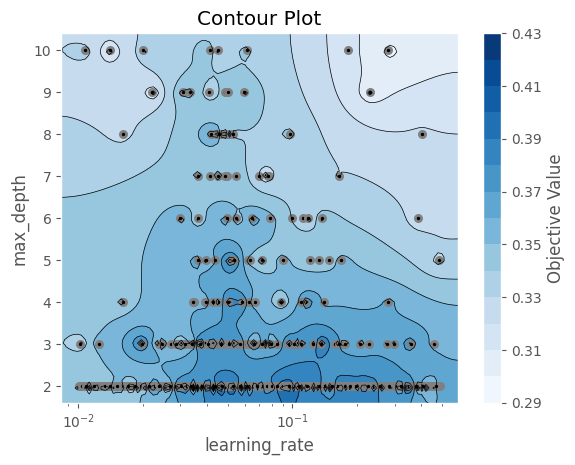

In [80]:
plot_contour(study_xgboost, ["learning_rate", "max_depth"])

plt.show()

In [82]:
plt.style.use("default")

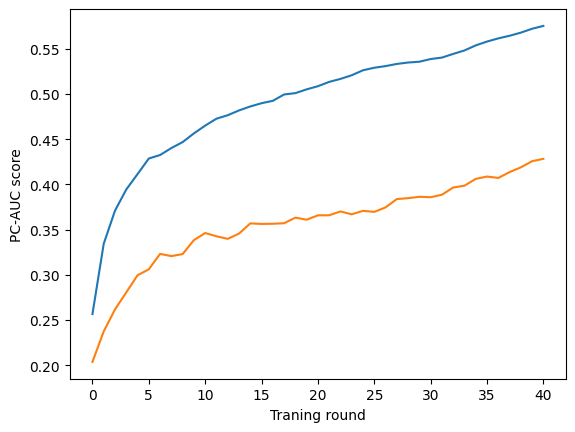

In [83]:
plt.plot(logs_xgboost["train_auc"][371])
plt.plot(logs_xgboost["val_auc"][371])

plt.xlabel("Traning round")
plt.ylabel("PC-AUC score")
plt.savefig("xgboost_validation.png")

In [102]:
# how many boosting rounds were performed on 
len(logs_xgboost["train_auc"][371])

41

In [86]:
xgb_tuned = xgb.XGBClassifier(
    n_estimators=41,
    **study_xgboost.best_params
)

# train tuned model 
xgb_tuned.fit(df_train[reg_cols], df_train.status)
# predict probabilities of the minority class
probs = xgb_tuned.predict_proba(df_test[reg_cols])[:, 1]
y_pred = xgb_tuned.predict(df_test[reg_cols])

res_xgb_tuned = calc_precision_recall_values(
    y_true=df_test.status, y_probs=probs
)

<h4>XGBoost + ROS</h4>

In [89]:
fold = RepeatedStratifiedKFold(n_splits=6, n_repeats=2, random_state=42)

In [90]:
def objective_xgboost_ros(trial, df: pd.DataFrame):
    
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.00001, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.00001, 0.1, log=True),
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "gamma": trial.suggest_float("gamma", 0.01, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0, 1),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 2),
        "early_stopping_rounds": 10
    }
    
    val_auc_scores, train_auc_scores = [], []
    val_last_best_scores = []
    
    for train_idx, val_idx in fold.split(df[reg_cols], df.status):
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # copy minority class using Random oversampler
        df_train_ros = ros_oversampler(df_train)
        # split data into train and validation then calculate target PR-AUC score
        dtrain = xgb.DMatrix(df_train_ros[reg_cols], label=df_train_ros.status)
        dval = xgb.DMatrix(df_val[reg_cols], label=df_val.status)
        
        evals_result = {}
        
        model = xgb.XGBClassifier(**params)

        # Fit the model with early stopping
        res = model.fit(
            df_train[reg_cols], 
            df_train.status, 
            eval_set=[
                (df_train_ros[reg_cols], df_train_ros.status), 
                (df_val[reg_cols], df_val.status)
            ],
            verbose=False
        )
        
        evals_result = model.evals_result()
        
        train_auc_scores.append(evals_result["validation_0"]["aucpr"])
        val_auc_scores.append(evals_result["validation_1"]["aucpr"])
        val_last_best_scores.append(evals_result["validation_1"]["aucpr"][-1])
          
    logs_xgboost_ros["train_auc"].append(train_auc_scores)
    logs_xgboost_ros["val_auc"].append(val_auc_scores)
    
    return np.array(val_last_best_scores).mean()

In [91]:
logs_xgboost_ros = {
    "train_auc": [],
    "val_auc": []
}

study_xgboost_ros = optuna.create_study(
    direction="maximize",
)

study_xgboost_ros.optimize(
    partial(objective_xgboost_ros, df=df_train), 
    n_trials=200
)

[I 2023-05-22 22:48:03,337] A new study created in memory with name: no-name-010a1751-5b34-469e-9397-852b0f72259b
[I 2023-05-22 22:48:05,090] Trial 0 finished with value: 0.30485871074339405 and parameters: {'learning_rate': 0.09613833849884718, 'max_depth': 8, 'reg_alpha': 0.003408410430486896, 'reg_lambda': 0.003557110582221984, 'subsample': 0.6777855242063966, 'gamma': 0.03087415776592021, 'colsample_bytree': 0.8563171259471177, 'scale_pos_weight': 1.7627937728729022}. Best is trial 0 with value: 0.30485871074339405.
[I 2023-05-22 22:48:06,740] Trial 1 finished with value: 0.32145607912647917 and parameters: {'learning_rate': 0.02577363447869846, 'max_depth': 7, 'reg_alpha': 0.04291320659930363, 'reg_lambda': 0.04280315246724306, 'subsample': 0.8267378351015162, 'gamma': 0.9086887395396199, 'colsample_bytree': 0.49938905386373134, 'scale_pos_weight': 1.096037732540359}. Best is trial 1 with value: 0.32145607912647917.
[I 2023-05-22 22:48:08,453] Trial 2 finished with value: 0.248991

[I 2023-05-22 22:48:26,636] Trial 19 finished with value: 0.3600069289616434 and parameters: {'learning_rate': 0.0676821857610164, 'max_depth': 3, 'reg_alpha': 0.00029154526508418305, 'reg_lambda': 0.0005099440444785656, 'subsample': 0.7544163290811463, 'gamma': 0.4226454219540926, 'colsample_bytree': 0.27785292516997195, 'scale_pos_weight': 1.247287000275449}. Best is trial 19 with value: 0.3600069289616434.
[I 2023-05-22 22:48:27,582] Trial 20 finished with value: 0.3415945953900414 and parameters: {'learning_rate': 0.06745956558772358, 'max_depth': 3, 'reg_alpha': 0.0010087550117301436, 'reg_lambda': 0.0003958545122404403, 'subsample': 0.6929217013972205, 'gamma': 0.2635125085657428, 'colsample_bytree': 0.5918064151337679, 'scale_pos_weight': 1.2691867610618075}. Best is trial 19 with value: 0.3600069289616434.
[I 2023-05-22 22:48:28,536] Trial 21 finished with value: 0.34271514592999835 and parameters: {'learning_rate': 0.06729875871235116, 'max_depth': 3, 'reg_alpha': 0.0017238385

[I 2023-05-22 22:48:45,019] Trial 39 finished with value: 0.34195660594619953 and parameters: {'learning_rate': 0.2126914820988128, 'max_depth': 3, 'reg_alpha': 0.0006287963894665716, 'reg_lambda': 0.06304221042366522, 'subsample': 0.7407046711486427, 'gamma': 0.4542390266960901, 'colsample_bytree': 0.3385940185947479, 'scale_pos_weight': 1.0351223338647795}. Best is trial 19 with value: 0.3600069289616434.
[I 2023-05-22 22:48:45,998] Trial 40 finished with value: 0.3205497829756253 and parameters: {'learning_rate': 0.10337297839052298, 'max_depth': 5, 'reg_alpha': 0.00028032195372679506, 'reg_lambda': 0.001176500789780299, 'subsample': 0.8587629834250365, 'gamma': 0.8155897916574442, 'colsample_bytree': 0.18615848799768275, 'scale_pos_weight': 1.3551432946680961}. Best is trial 19 with value: 0.3600069289616434.
[I 2023-05-22 22:48:46,823] Trial 41 finished with value: 0.3470093107042729 and parameters: {'learning_rate': 0.15432632171047958, 'max_depth': 2, 'reg_alpha': 0.002093324724

[I 2023-05-22 22:49:04,053] Trial 59 finished with value: 0.3669996024595726 and parameters: {'learning_rate': 0.05968549673290416, 'max_depth': 2, 'reg_alpha': 8.980616192232216e-05, 'reg_lambda': 0.011205320737815702, 'subsample': 0.8436599435226326, 'gamma': 0.22894266787618545, 'colsample_bytree': 0.31520059863968586, 'scale_pos_weight': 1.240349508433379}. Best is trial 59 with value: 0.3669996024595726.
[I 2023-05-22 22:49:04,986] Trial 60 finished with value: 0.3540611701232939 and parameters: {'learning_rate': 0.06391341268206714, 'max_depth': 3, 'reg_alpha': 8.040713551981986e-05, 'reg_lambda': 0.007329012561807241, 'subsample': 0.8453149811741979, 'gamma': 0.23697780194788023, 'colsample_bytree': 0.2110332905353318, 'scale_pos_weight': 1.2481467420213492}. Best is trial 59 with value: 0.3669996024595726.
[I 2023-05-22 22:49:06,047] Trial 61 finished with value: 0.3567634402753382 and parameters: {'learning_rate': 0.05929060464456436, 'max_depth': 2, 'reg_alpha': 4.24537824200

[I 2023-05-22 22:49:23,933] Trial 79 finished with value: 0.3291141112035654 and parameters: {'learning_rate': 0.06918199638603377, 'max_depth': 3, 'reg_alpha': 0.00033253322812394555, 'reg_lambda': 0.0021837557736059136, 'subsample': 0.772561901382319, 'gamma': 0.24474279404952315, 'colsample_bytree': 0.16228159868137, 'scale_pos_weight': 1.2263481714862736}. Best is trial 76 with value: 0.36891032145690567.
[I 2023-05-22 22:49:24,937] Trial 80 finished with value: 0.31291830953309957 and parameters: {'learning_rate': 0.07517215805725315, 'max_depth': 5, 'reg_alpha': 0.00022835817666630578, 'reg_lambda': 0.010757209015976163, 'subsample': 0.7310302802497732, 'gamma': 0.17618166093524817, 'colsample_bytree': 0.22651472253386815, 'scale_pos_weight': 1.3748640952925164}. Best is trial 76 with value: 0.36891032145690567.
[I 2023-05-22 22:49:25,900] Trial 81 finished with value: 0.3559237147865406 and parameters: {'learning_rate': 0.08437467369502538, 'max_depth': 2, 'reg_alpha': 0.0001365

[I 2023-05-22 22:49:42,559] Trial 99 finished with value: 0.3088577913063044 and parameters: {'learning_rate': 0.143682367542143, 'max_depth': 6, 'reg_alpha': 9.443571199281478e-05, 'reg_lambda': 0.009095673520332024, 'subsample': 0.8206096917719589, 'gamma': 0.4324191866740798, 'colsample_bytree': 0.36883367879480733, 'scale_pos_weight': 1.1572623684147263}. Best is trial 76 with value: 0.36891032145690567.
[I 2023-05-22 22:49:43,560] Trial 100 finished with value: 0.3510142349686041 and parameters: {'learning_rate': 0.07760720831064263, 'max_depth': 3, 'reg_alpha': 0.0001659830660804381, 'reg_lambda': 0.006633148593458786, 'subsample': 0.7940206417060559, 'gamma': 0.33241782797354974, 'colsample_bytree': 0.3439865649643028, 'scale_pos_weight': 1.1933235070440718}. Best is trial 76 with value: 0.36891032145690567.
[I 2023-05-22 22:49:44,640] Trial 101 finished with value: 0.36576583017512526 and parameters: {'learning_rate': 0.09094816492657037, 'max_depth': 2, 'reg_alpha': 0.00010756

[I 2023-05-22 22:50:02,500] Trial 119 finished with value: 0.3587135067695737 and parameters: {'learning_rate': 0.1354751206236752, 'max_depth': 2, 'reg_alpha': 2.9966126868576968e-05, 'reg_lambda': 0.017952751622086458, 'subsample': 0.7547229070379294, 'gamma': 0.1583899458845257, 'colsample_bytree': 0.24210828758554165, 'scale_pos_weight': 1.0826753558333615}. Best is trial 110 with value: 0.3790503270735511.
[I 2023-05-22 22:50:03,380] Trial 120 finished with value: 0.3360837553451855 and parameters: {'learning_rate': 0.12458394306066765, 'max_depth': 2, 'reg_alpha': 2.017023213539691e-05, 'reg_lambda': 0.04374621703373854, 'subsample': 0.7044954056357413, 'gamma': 0.15036806336457836, 'colsample_bytree': 0.15871307967326295, 'scale_pos_weight': 1.0591756989775136}. Best is trial 110 with value: 0.3790503270735511.
[I 2023-05-22 22:50:04,492] Trial 121 finished with value: 0.3720395912913097 and parameters: {'learning_rate': 0.1698507562361143, 'max_depth': 2, 'reg_alpha': 4.7140301

[I 2023-05-22 22:50:22,913] Trial 139 finished with value: 0.3552125423515631 and parameters: {'learning_rate': 0.10969766414495839, 'max_depth': 2, 'reg_alpha': 6.0998432533950904e-05, 'reg_lambda': 0.021671156390157712, 'subsample': 0.7741061276798095, 'gamma': 0.18408111946019662, 'colsample_bytree': 0.3228354855726495, 'scale_pos_weight': 1.1361371271110667}. Best is trial 110 with value: 0.3790503270735511.
[I 2023-05-22 22:50:24,010] Trial 140 finished with value: 0.27701405811781826 and parameters: {'learning_rate': 0.17300128294128805, 'max_depth': 8, 'reg_alpha': 4.155699550322389e-05, 'reg_lambda': 0.00763069310216407, 'subsample': 0.7991296570713126, 'gamma': 0.08112652754637131, 'colsample_bytree': 0.14743029433076554, 'scale_pos_weight': 1.0942561579300871}. Best is trial 110 with value: 0.3790503270735511.
[I 2023-05-22 22:50:24,966] Trial 141 finished with value: 0.3632986140511998 and parameters: {'learning_rate': 0.14265047722296972, 'max_depth': 2, 'reg_alpha': 2.3766

[I 2023-05-22 22:50:42,498] Trial 159 finished with value: 0.32259889655267193 and parameters: {'learning_rate': 0.22881781729059375, 'max_depth': 2, 'reg_alpha': 1.8158943177911926e-05, 'reg_lambda': 0.05342358220925681, 'subsample': 0.8032862858630163, 'gamma': 0.18087171588429252, 'colsample_bytree': 0.1716883982576779, 'scale_pos_weight': 1.0539881216945597}. Best is trial 110 with value: 0.3790503270735511.
[I 2023-05-22 22:50:43,375] Trial 160 finished with value: 0.2912331147966442 and parameters: {'learning_rate': 0.14857457977146465, 'max_depth': 6, 'reg_alpha': 3.65190665204447e-05, 'reg_lambda': 0.06228036378712311, 'subsample': 0.7783116191661416, 'gamma': 0.10956229065998523, 'colsample_bytree': 0.19899139178322733, 'scale_pos_weight': 1.1121343270299815}. Best is trial 110 with value: 0.3790503270735511.
[I 2023-05-22 22:50:44,368] Trial 161 finished with value: 0.37934733654144276 and parameters: {'learning_rate': 0.15697062880187249, 'max_depth': 2, 'reg_alpha': 1.26486

[I 2023-05-22 22:51:01,902] Trial 179 finished with value: 0.3615751141980408 and parameters: {'learning_rate': 0.16230126268736267, 'max_depth': 2, 'reg_alpha': 1.7276959734922772e-05, 'reg_lambda': 0.05599996810952945, 'subsample': 0.8083152455455345, 'gamma': 0.24743651172618233, 'colsample_bytree': 0.2997450675355868, 'scale_pos_weight': 1.136187740237679}. Best is trial 163 with value: 0.37987830493999586.
[I 2023-05-22 22:51:02,850] Trial 180 finished with value: 0.2849882218351127 and parameters: {'learning_rate': 0.1990425922465793, 'max_depth': 7, 'reg_alpha': 2.0290174051728637e-05, 'reg_lambda': 0.03373455978023264, 'subsample': 0.8397378369107198, 'gamma': 0.1911958245615645, 'colsample_bytree': 0.21642229576518912, 'scale_pos_weight': 1.0851749593026725}. Best is trial 163 with value: 0.37987830493999586.
[I 2023-05-22 22:51:03,845] Trial 181 finished with value: 0.3654298732539453 and parameters: {'learning_rate': 0.1522736991053842, 'max_depth': 2, 'reg_alpha': 1.2596816

[I 2023-05-22 22:51:21,107] Trial 199 finished with value: 0.34337884085179443 and parameters: {'learning_rate': 0.10223755356164967, 'max_depth': 2, 'reg_alpha': 1.901611091321758e-05, 'reg_lambda': 0.0576073044555786, 'subsample': 0.8130878726365427, 'gamma': 0.012174447642389195, 'colsample_bytree': 0.2141374430787575, 'scale_pos_weight': 1.1705536794720153}. Best is trial 163 with value: 0.37987830493999586.


In [92]:
study_xgboost_ros.trials_dataframe().sort_values(by="value", ascending=False).head(5)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_gamma,params_learning_rate,params_max_depth,params_reg_alpha,params_reg_lambda,params_scale_pos_weight,params_subsample,state
163,163,0.379878,2023-05-22 22:50:45.289866,2023-05-22 22:50:46.366480,0 days 00:00:01.076614,0.269751,0.162774,0.178461,2,0.000019,0.047030,1.044886,0.773288,COMPLETE
161,161,0.379347,2023-05-22 22:50:43.376629,2023-05-22 22:50:44.367931,0 days 00:00:00.991302,0.256526,0.137897,0.156971,2,0.000013,0.037010,1.031915,0.761703,COMPLETE
110,110,0.379050,2023-05-22 22:49:52.315233,2023-05-22 22:49:53.379201,0 days 00:00:01.063968,0.240653,0.156201,0.146271,2,0.000050,0.022104,1.085232,0.760100,COMPLETE
113,113,0.373926,2023-05-22 22:49:55.606280,2023-05-22 22:49:56.702775,0 days 00:00:01.096495,0.248487,0.129510,0.156466,2,0.000051,0.030224,1.082756,0.777638,COMPLETE
121,121,0.372040,2023-05-22 22:50:03.382083,2023-05-22 22:50:04.492086,0 days 00:00:01.110003,0.262206,0.176557,0.169851,2,0.000047,0.015263,1.033010,0.771053,COMPLETE


In [95]:
np.mean([len(el) for el in logs_xgboost_ros["train_auc"][163]])

30.166666666666668

In [96]:
xgb_tuned_ros = xgb.XGBClassifier(
    n_estimators=31,
    **study_xgboost_ros.best_params
)

# train tuned model 
xgb_tuned_ros.fit(df_train_ros[reg_cols], df_train_ros.status)
# predict probabilities of the minority class
probs = xgb_tuned_ros.predict_proba(df_test[reg_cols])[:, 1]
y_pred = xgb_tuned_ros.predict(df_test[reg_cols])

res_xgb_tuned_ros = calc_precision_recall_values(
    y_true=df_test.status, y_probs=probs
)

In [103]:
print(classification_report(df_test.status, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89       307
           1       0.28      0.61      0.38        33

    accuracy                           0.81       340
   macro avg       0.61      0.72      0.63       340
weighted avg       0.89      0.81      0.84       340



<module 'matplotlib.pyplot' from '/Users/borokoko/.pyenv/versions/3.11.0/lib/python3.11/site-packages/matplotlib/pyplot.py'>

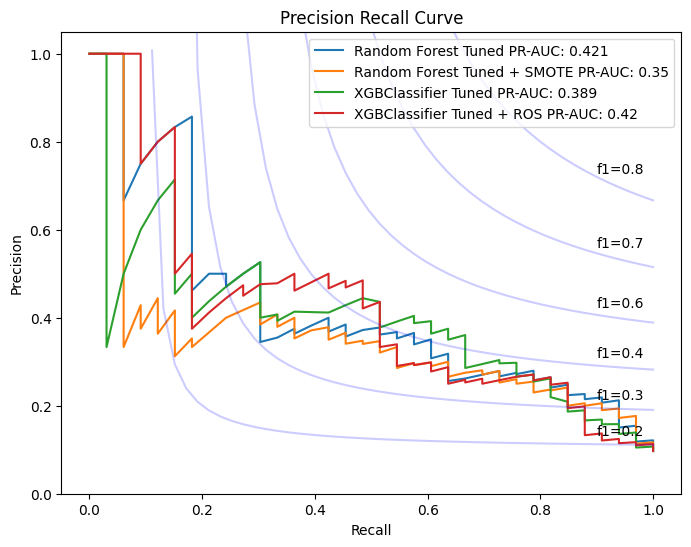

In [104]:
plot_precision_recall_curves(
    model_res={
        "Random Forest Tuned": res_rf_tuned,
        "Random Forest Tuned + SMOTE": res_rf_smotenc_tuned,
        "XGBClassifier Tuned": res_xgb_tuned,
        "XGBClassifier Tuned + ROS": res_xgb_tuned_ros
    }
)

<h4>Cross validation of obtained models</h4>

In [105]:
def do_nothing(df: pd.DataFrame) -> pd.DataFrame:
    return df

In [106]:
# model name + callback that tranforms data before fit
val_models = {
    "Logistic Regression": {"model": logr, "df_callback": do_nothing},
    "Logistic Regression Tuned": {"model": logr_tuned, "df_callback": do_nothing},
    "Logistic Regression Tuned + ROS": {"model": logr_ros_tuned, "df_callback": ros_oversampler},
    "Logistic Regression Tuned + SMOTENC": {"model": logr_smotenc_tuned, "df_callback": smotenc_oversampler},
    "RandomForest Tuned": {"model": rf_tuned, "df_callback": do_nothing},
    "RandomForest Tuned + SMOTENC": {"model": rf_smotenc_tuned, "df_callback": smotenc_oversampler},
    "XGBoost Tuned": {"model": xgb_tuned, "df_callback": do_nothing},
    "XGBoost Tuned + ROS": {"model": xgb_tuned_ros, "df_callback": ros_oversampler}
}

In [107]:
def crossval_models(
    val_models: Dict[str, Dict[str, Any]],
    fold: RepeatedStratifiedKFold, 
    df: pd.DataFrame
) -> Dict[str, List[float]]:
    data = {
        name: [] for name in val_models
    }
    
    for train_idx, val_idx in fold.split(df[reg_cols], df.status):
        for name, model_dict in val_models.items():
            df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
            model, func = model_dict["model"], model_dict["df_callback"]
            # transform data and fit the model with it
            df_train = func(df_train)
            model.fit(df_train[reg_cols], df_train.status)
            # calculate PR-AUC score for validation set
            probs_val = model.predict_proba(df_val[reg_cols])[:, 1]
            precisions, recalls, _ = precision_recall_curve(df_val.status, probs_val)
            data[name].append(
                auc(recalls, precisions)
            )
        
    return data    

In [109]:
fold = RepeatedStratifiedKFold(n_splits=6, n_repeats=50, random_state=42)

cval_data = crossval_models(val_models, fold, df_train)

pd.DataFrame(cval_data).mean().to_frame()

,0
Logistic Regression,0.345921
Logistic Regression Tuned,0.364840
Logistic Regression Tuned + ROS,0.348584
Logistic Regression Tuned + SMOTENC,0.360475
RandomForest Tuned,0.346766
RandomForest Tuned + SMOTENC,0.329052
XGBoost Tuned,0.363865
XGBoost Tuned + ROS,0.357304


In [110]:
pd.DataFrame(cval_data).mean().to_frame()

,0
Logistic Regression,0.345921
Logistic Regression Tuned,0.364840
Logistic Regression Tuned + ROS,0.348584
Logistic Regression Tuned + SMOTENC,0.360475
RandomForest Tuned,0.346766
RandomForest Tuned + SMOTENC,0.329052
XGBoost Tuned,0.363865
XGBoost Tuned + ROS,0.357304


<h3>Feature importances and statistical significance</h3>

In [111]:
def bootstrap_tuned_model(
    model, 
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    n_samples=1000,
    df_callback: Callable = do_nothing
) -> Dict[str, List[Any]]:
    
    stats = {
        "pr-auc": [],
        "feature_importances": []
    }
    
    for _ in tqdm(range(n_samples)):
        df_sampled = df_train.sample(
            df_train.shape[0], replace=True
        )
        df_sampled = df_callback(df_sampled) # transform data before fit if necessary
        model.fit(df_sampled[reg_cols], df_sampled.status)
        
        # calculate PR-AUC score for validation set
        probs_test = model.predict_proba(df_test[reg_cols])[:, 1]
        precisions, recalls, _ = precision_recall_curve(df_test.status, probs_test)
        stats["pr-auc"].append(
            auc(recalls, precisions)
        )
        stats["feature_importances"].append(model.feature_importances_)
        
    return stats

In [112]:
bs_rf_tuned = bootstrap_tuned_model(rf_tuned, df_train=df_train, df_test=df_test)

100%|███████████████████████████████████████| 1000/1000 [19:42<00:00,  1.18s/it]


<h4>Permutation importance</h4>

In [113]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

In [114]:
def pr_auc_minority(y_true, y_proba):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    return auc(recall, precision)

pr_auc_minority_scorer = make_scorer(pr_auc_minority, needs_proba=True)

In [115]:
rf_perm = permutation_importance(
    rf_tuned, df_test[reg_cols], df_test.status, n_repeats=500, scoring="average_precision"
)

In [145]:
df_rf_perm = pd.DataFrame({
    "variable": reg_cols,
    "permutation_importance": rf_perm["importances_mean"]
})

df_rf_perm.sort_values(by="permutation_importance", ascending=False).round(4)

,variable,permutation_importance
16,Finance_Investments,0.0441
3,total_rev_avg,0.0416
12,Resources_Materials,0.0296
13,IT_Software,0.0269
6,net_income_avg,0.0234
5,basic_eps_avg,0.0192
2,total_cap_avg,0.0191
10,Healthcare,0.0104
7,num_employees,0.0091
1,total_equity_avg,0.0056


In [118]:
data_rf_tuned = {
    col: [] for col in reg_cols
}

for el in bs_rf_tuned["feature_importances"]:
    for val, col in zip(el, reg_cols):
        data_rf_tuned[col].append(val)

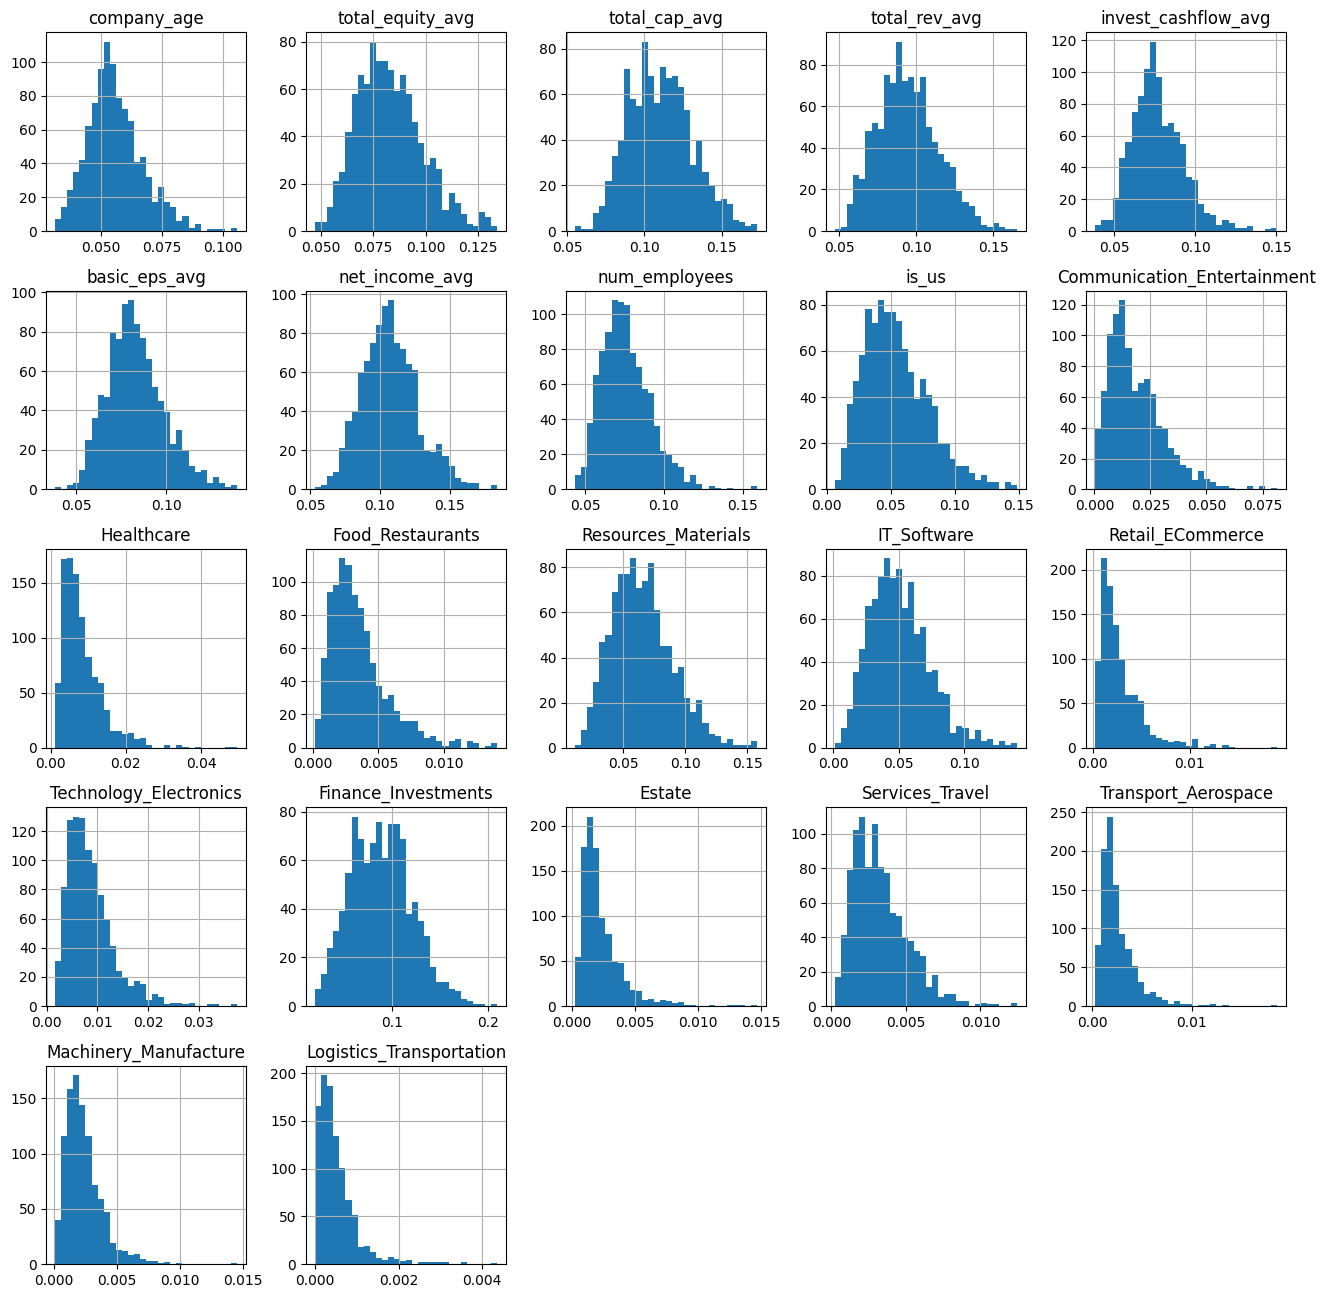

In [119]:
pd.DataFrame(data_rf_tuned).hist(bins=30, figsize=(16, 16))
plt.show()

In [120]:
pd.DataFrame(data_rf_tuned).agg(["mean"]).T.sort_values(by="mean", ascending=False)

,mean
total_cap_avg,0.110217
net_income_avg,0.107224
total_rev_avg,0.094493
Finance_Investments,0.089402
basic_eps_avg,0.083010
total_equity_avg,0.082942
invest_cashflow_avg,0.076927
num_employees,0.076076
Resources_Materials,0.065294
company_age,0.056012


In [121]:
xgb_tuned_ros = xgb.XGBClassifier(
    n_estimators=49,
    **study_xgboost_ros.best_params
)

In [122]:
bs_xgb_tuned_ros = bootstrap_tuned_model(
    model=xgb_tuned_ros, df_train=df_train, df_test=df_test, n_samples=5000,
    df_callback=ros_oversampler
)

100%|███████████████████████████████████████| 5000/5000 [06:10<00:00, 13.48it/s]


In [123]:
data_xgb_tuned_ros = {
    col: [] for col in reg_cols
}

for el in bs_xgb_tuned_ros["feature_importances"]:
    for val, col in zip(el, reg_cols):
        data_xgb_tuned_ros[col].append(val)

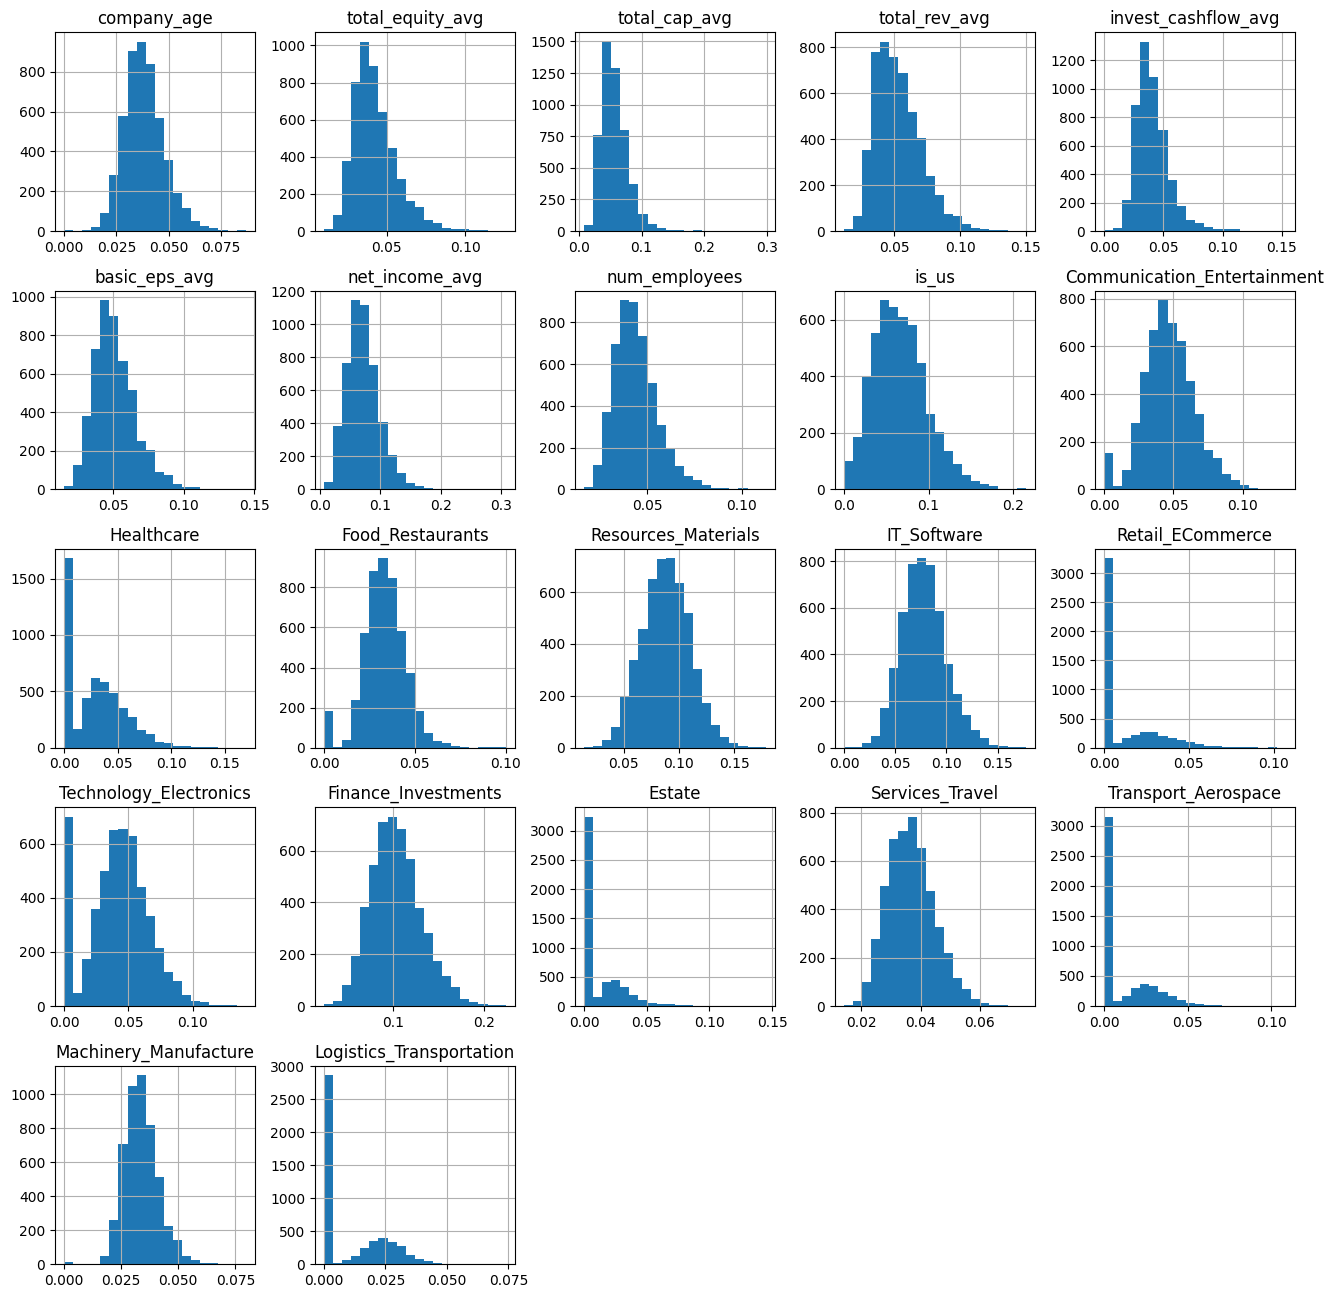

In [124]:
pd.DataFrame(data_xgb_tuned_ros).hist(bins=20, figsize=(16, 16))
plt.show()

In [149]:
pd.DataFrame(
    data_xgb_tuned_ros).agg(
    ["mean"]
).T.sort_values(by="mean", ascending=False).round(4)

,mean
Finance_Investments,0.1036
Resources_Materials,0.0883
IT_Software,0.0780
net_income_avg,0.0715
is_us,0.0665
total_cap_avg,0.0567
total_rev_avg,0.0530
basic_eps_avg,0.0512
Communication_Entertainment,0.0470
num_employees,0.0440


In [126]:
xgb_perm = permutation_importance(
    xgb_tuned_ros, df_test[reg_cols], 
    df_test.status, n_repeats=500, scoring="average_precision",
)

In [127]:
df_xgb_perm = pd.DataFrame({
    "variable": reg_cols,
    "permutation_importance": xgb_perm["importances_mean"]
})
df_xgb_perm.sort_values(by="permutation_importance", ascending=False)

,variable,permutation_importance
2,total_cap_avg,0.048137
13,IT_Software,0.029268
7,num_employees,0.024515
8,is_us,0.024194
16,Finance_Investments,0.022552
12,Resources_Materials,0.020218
4,invest_cashflow_avg,0.018145
6,net_income_avg,0.013371
1,total_equity_avg,0.013171
10,Healthcare,0.009135


In [150]:
df_xgb_perm.sort_values(by="permutation_importance", ascending=False).round(4)

,variable,permutation_importance
2,total_cap_avg,0.0481
13,IT_Software,0.0293
7,num_employees,0.0245
8,is_us,0.0242
16,Finance_Investments,0.0226
12,Resources_Materials,0.0202
4,invest_cashflow_avg,0.0181
6,net_income_avg,0.0134
1,total_equity_avg,0.0132
10,Healthcare,0.0091


In [128]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

<h3>Variance Inflation Factor (VIF)</h3>

In [129]:
# Calculate VIF values for each predictor variable
vif = [variance_inflation_factor(Xs, i) for i in range(Xs.shape[1])]

pd.DataFrame({
    "column": reg_cols,
    "vif": vif
})

,column,vif
0,company_age,1.368895
1,total_equity_avg,1.620792
2,total_cap_avg,5.176391
3,total_rev_avg,3.007210
4,invest_cashflow_avg,3.545557
5,basic_eps_avg,1.093395
6,net_income_avg,2.793462
7,num_employees,2.137512
8,is_us,1.406819
9,Communication_Entertainment,1.151976


In [130]:
# define statsmodels.formula for logit model
formula = "status ~ " + " + ".join(reg_cols[:-1])

model = smf.logit(
    formula=formula, data=df_scaled
).fit(disp=0, method="bfgs", maxiter=5000)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 status   No. Observations:                 1696
Model:                          Logit   Df Residuals:                     1674
Method:                           MLE   Df Model:                           21
Date:                Tue, 23 May 2023   Pseudo R-squ.:                  0.2393
Time:                        00:24:06   Log-Likelihood:                -415.05
converged:                       True   LL-Null:                       -545.61
Covariance Type:            nonrobust   LLR p-value:                 2.402e-43
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -3.6073      0.658     -5.480      0.000      -4.898      -2.317
company_age                     0.1164      0.092      1.272      0.203      -0.063       0.296
total_equity_avg               -0.1161      0.215     -0.540      0.589      -0.538       0.306
total_cap_avg                   0.2499      0.162      1.545      0.122      -0.067       0.567
total_rev_avg                   0.1778      0.118      1.505      0.132      -0.054       0.409
invest_cashflow_avg             0.0899      0.116      0.777      0.437      -0.137       0.316
basic_eps_avg                  -0.0226      0.087     -0.261      0.794      -0.192       0.147
net_income_avg                  0.0347      0.117      0.297      0.766      -0.194       0.264
num_employees                   0.3306      0.127      2.600      0.009       0.081       0.580
is_us                           0.9576      0.242      3.963      0.000       0.484       1.431
Communication_Entertainment     1.6026      0.690      2.323      0.020       0.250       2.955
Healthcare                     -0.4608      0.751     -0.613      0.540      -1.934       1.012
Food_Restaurants               -0.5029      0.868     -0.579      0.563      -2.205       1.199
Resources_Materials            -0.9612      0.765     -1.256      0.209      -2.461       0.538
IT_Software                     1.7502      0.662      2.646      0.008       0.454       3.047
Retail_ECommerce                0.3203      0.719      0.445      0.656      -1.090       1.730
Technology_Electronics         -0.2248      0.779     -0.289      0.773      -1.751       1.301
Finance_Investments             1.8808      0.660      2.848      0.004       0.587       3.175
Estate                          0.6088      0.735      0.828      0.408      -0.832       2.050
Services_Travel               -12.9614    342.949     -0.038      0.970    -685.130     659.207
Transport_Aerospace             0.1151      0.759      0.152      0.879      -1.373       1.604
Machinery_Manufacture          -0.4917      0.962     -0.511      0.609      -2.376       1.393
===============================================================================================
"""

<h4>Bootstrapped pvalues and coefficients</h4>

In [131]:
import warnings
from statsmodels.tools.sm_exceptions import HessianInversionWarning

warnings.simplefilter('ignore', HessianInversionWarning)

In [132]:
def bootstrap_statsmodels_logit(
    formula: str, df: pd.DataFrame, n_samples=1000
) -> Dict[str, list]:
    
    data = {
        "pvalues": [],
        "coefs": []
    }
    
    for _ in tqdm(range(n_samples)):
        
        df_sampled = df.sample(df.shape[0], replace=True)
        
        model = smf.logit(formula=formula, data=df_sampled).fit(
             disp=0, method="bfgs", maxiter=5000
        )
        
        data["pvalues"].append(model.pvalues.values)
        data["coefs"].append(model.params.values)
        
    return data

In [133]:
bs_logit = bootstrap_statsmodels_logit(formula, df_scaled, n_samples=5000)

100%|███████████████████████████████████████| 5000/5000 [13:14<00:00,  6.29it/s]


In [134]:
def q5(x):
    return x.quantile(.05)

def q95(x):
    return x.quantile(.95)

In [135]:
df_pvalues = pd.DataFrame(
    np.array(bs_logit["pvalues"]), 
    columns=["intercept"] + reg_cols[:-1]
)

df_coefs = pd.DataFrame(
    np.array(bs_logit["coefs"]), 
    columns=["intercept"] + reg_cols[:-1]
)

In [136]:
df_c = df_coefs.agg([q5, "median", q95]).T
df_p = df_pvalues.agg([q5, "median", q95]).T

df_stats = pd.concat([df_c, df_p], axis=1)
df_stats.columns = [
    "q5_coef", "median_coef", "q95_coef", "q5_pval", "median_pval", "q95_pval"
]

df_stats

df_stats.style.applymap(
    lambda x: "background-color : #34eb71" 
    if x < 0.05 else 
    "background-color : #f4fc03" if (x >= 0.05 and x <= 0.1) else "",
    subset=pd.IndexSlice[:, "median_pval"]
).format(precision=3)

,q5_coef,median_coef,q95_coef,q5_pval,median_pval,q95_pval
intercept,-5.956,-3.719,-2.679,0.000,0.000,0.000
company_age,-0.053,0.114,0.270,0.003,0.211,0.901
total_equity_avg,-0.758,-0.113,0.549,0.034,0.482,0.847
total_cap_avg,-0.077,0.266,0.670,0.002,0.146,0.842
total_rev_avg,-0.072,0.179,0.402,0.001,0.158,0.882
invest_cashflow_avg,-0.068,0.099,0.356,0.021,0.395,0.935
basic_eps_avg,-0.160,-0.030,0.133,0.104,0.532,0.951
net_income_avg,-0.156,0.060,0.388,0.033,0.452,0.945
num_employees,0.117,0.348,0.579,0.000,0.009,0.396
is_us,0.574,0.970,1.423,0.000,0.000,0.015


<h4>Bootstrapped p-values for Wald's test</h4>

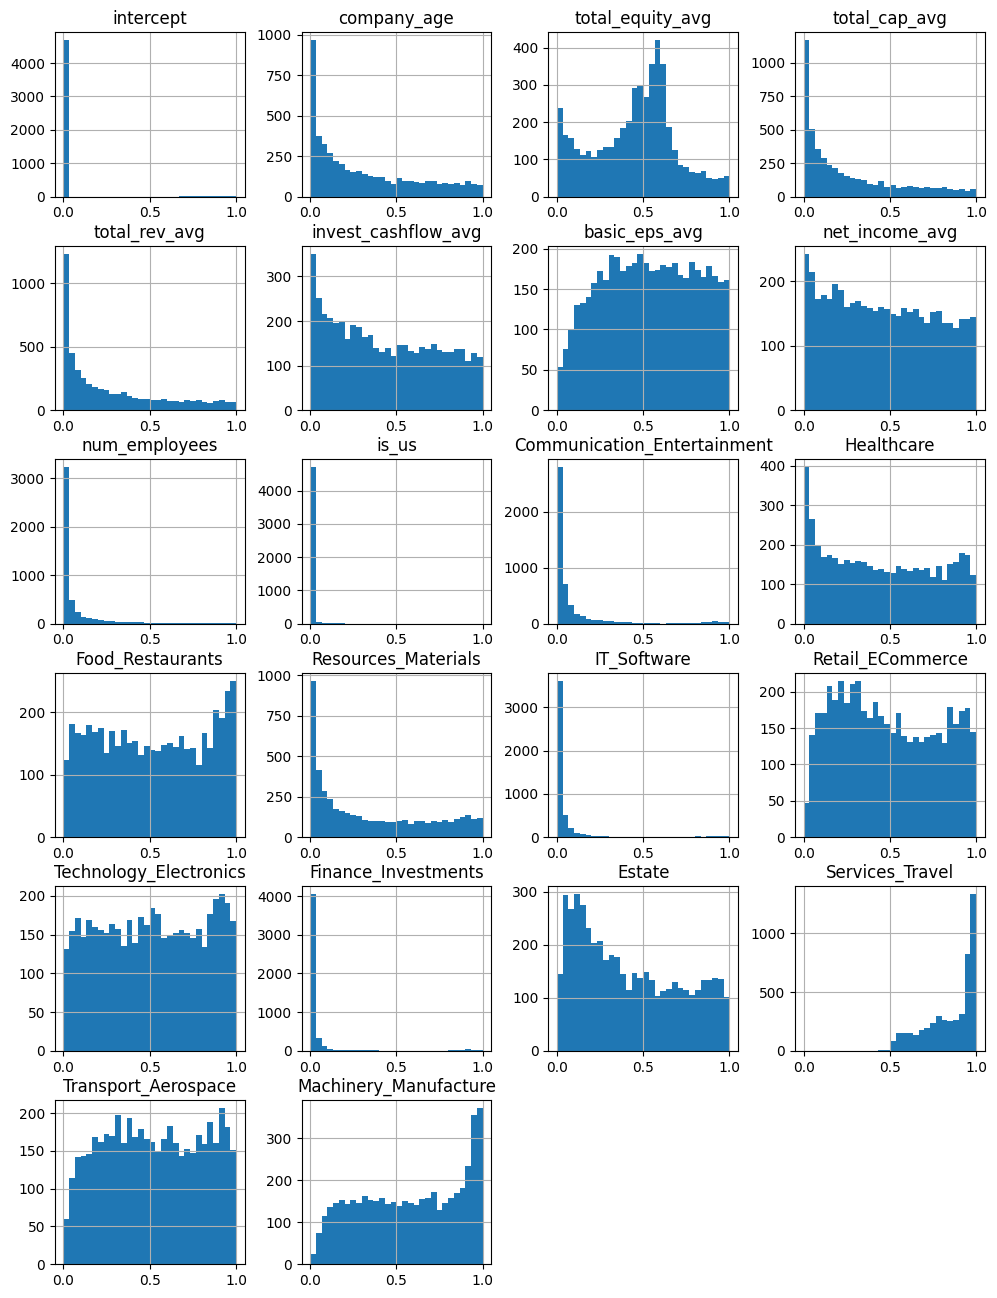

In [138]:
df_pvalues.hist(
    bins=30, figsize=(12, 16), range=(0, 1), layout=(6, 4)
)

plt.savefig("bootstrapped_pvalues.png", bbox_inches="tight")
plt.show()

<h4>Bootstrapped logistic regression's coefficients</h4>

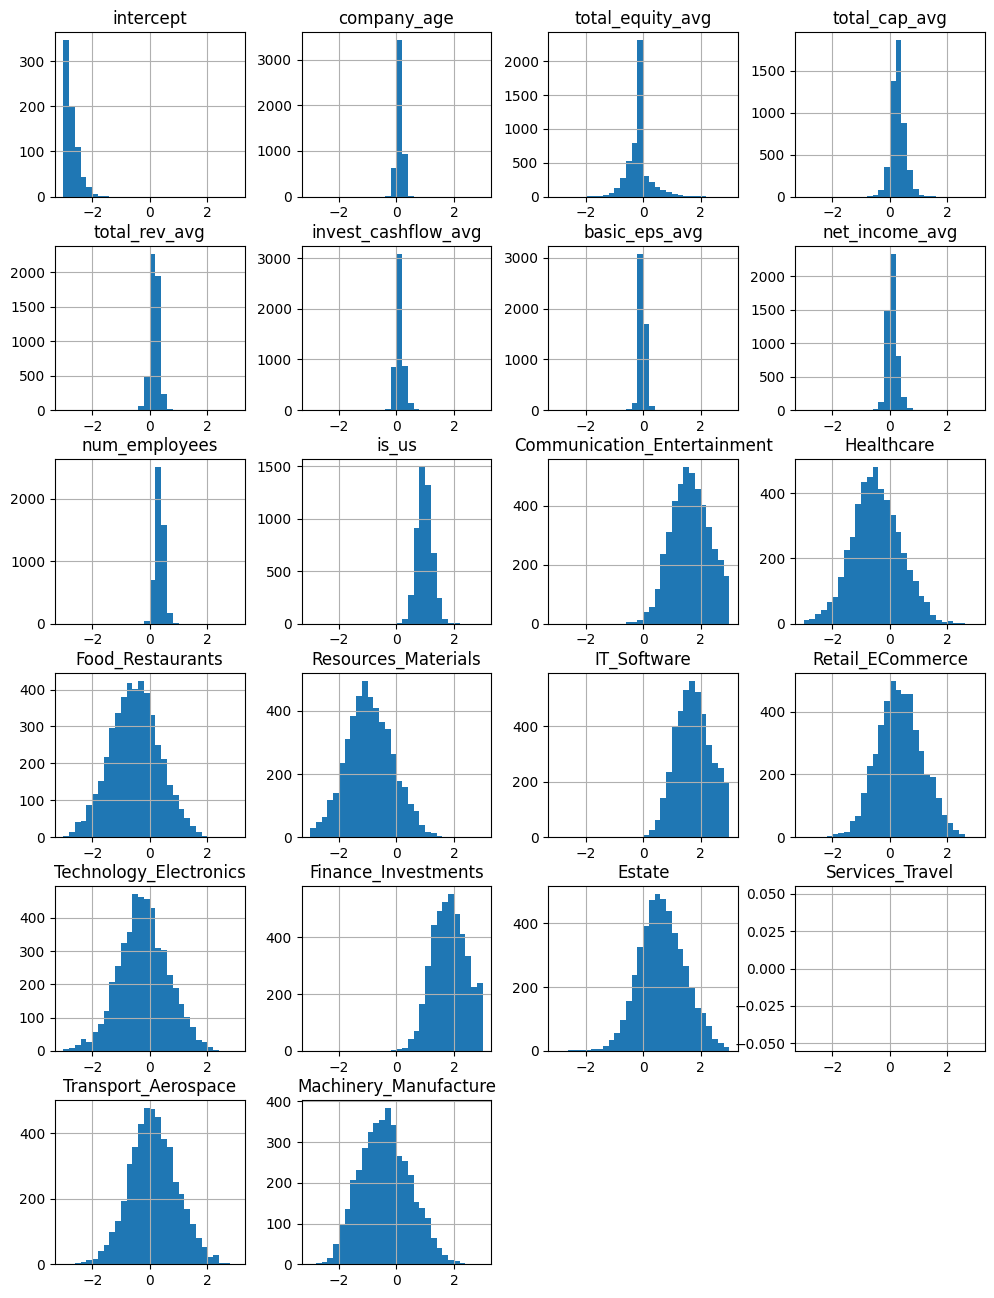

In [139]:
df_coefs = pd.DataFrame(
    np.array(bs_logit["coefs"]), 
    columns=["intercept"] + reg_cols[:-1]
)

df_coefs.hist(bins=30, figsize=(12, 16), layout=(6, 4), range=(-3, 3))
plt.savefig("bootstrapped_coefs.png", bbox_inches="tight")
plt.show()